# Environment Setup

## Once

In [1]:
# Change output format
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last_expr"

# Import packages
import warnings
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.cluster import KMeans
import json
import requests
#!pip install folium
import folium
import random
import imageio
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches
import matplotlib.colors as colors
import math
from io import BytesIO
#from tabulate import tabulate
import time
from chinese_calendar import is_workday, is_holiday
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import plot_importance
import xgboost as xgb


# Other settings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows', None)
#sns.set(font='SimHei')

# -*- coding: utf-8 -*- 
#import cx_Oracle
import os
#os.environ['NLS_LANG'] = 'SIMPLIFIED CHINESE_CHINA.UTF8'
from collections import Counter
# df.to_pickle('./Cache/cache_df_nd_2019.pkl')
# pd.read_pickle('samples')

## Control

In [2]:
#设置展示形式
#InteractiveShell.ast_node_interactivity = "last_expr"
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 20)

#设置目录
os.chdir('/Users/bryan/Documents/MetersBonwe/Data')
#os.chdir('/Users/bryan/Documents/Python/Data')
#weather = pd.read_csv('./Data/weather.csv', encoding = 'utf-16', delimiter = '\t')

#设置科学计数法
#np.set_printoptions(suppress=False)
np.set_printoptions(suppress=True)

# Read Data

## 客流

In [3]:
## inout data (BI数据)
# def load_bi_data(bi_name):
#     url = 'http://192.168.103.63:7777/analytics/saw.dll?GO&path=/users/hq01uh618/' + bi_name + '&Action=Extract&format=csv&NQUser=HQ01UH618&NQPassword=304558'
#     response = requests.get(url)
#     r = BytesIO(response.content)
#     return pd.read_csv(r, encoding = 'utf-16', delimiter = ',')

raw_cus_stm = pd.read_pickle('./spb_cus_inout_2018_now.pkl')
raw_cus_stm

,日历日(YYYY-MM-DD),门店ID,出店人数,进店人数
0,2018-01-01,A00298S473,6412,5631
1,2018-01-02,A00298S473,1050,881
2,2018-01-03,A00298S473,576,557
3,2018-01-04,A00298S473,738,569
4,2018-01-05,A00298S473,976,692
...,...,...,...,...
1025,2021-02-20,A00298S473,2214,1458
1026,2021-02-21,A00298S473,3036,1987
1027,2021-02-22,A00298S473,2076,1335
1028,2021-02-23,A00298S473,1807,1211


## 天气

In [4]:
raw_weather = pd.read_pickle('./weather_2018_now.pkl')
raw_weather

,日历日(YYYY-MM-DD),省份,城市,县区,天气,平均温度
0,2018-01-01,上海,上海,上海,阴,8.0
1,2018-01-01,上海,上海,嘉定,阴,8.0
2,2018-01-01,上海,上海,奉贤,阴,7.0
3,2018-01-01,上海,上海,宝山,阴,7.0
4,2018-01-01,上海,上海,崇明,阴,6.0
...,...,...,...,...,...,...
2994697,2021-04-03,黑龙江,齐齐哈尔,泰来,NaN,4.0
2994698,2021-04-03,黑龙江,齐齐哈尔,甘南,NaN,4.0
2994699,2021-04-03,黑龙江,齐齐哈尔,讷河,NaN,3.0
2994700,2021-04-03,黑龙江,齐齐哈尔,齐齐哈尔,NaN,4.0


In [5]:
#os.chdir('/project/datadir/wnb')
#weather = pd.read_csv('./Data/weather.csv', encoding = 'utf-16', delimiter = '\t')
#weather.shape

def clean_weather(df):
    #筛选城市
    df = df[df['县区'] == '重庆']
    #转换日期格式
    df['Date'] = pd.to_datetime(df['日历日(YYYY-MM-DD)'])
    #针对区县去重
    df = df.drop_duplicates(subset=['Date','城市'], keep='first')
    #筛选时间
    df = df[df['Date'] >= pd.to_datetime('2017-01-01')]
    df = df[df['Date'] <= pd.to_datetime('2021-01-06')]
    #dropna
    df = df.dropna()
    #天气情况
    weather_cons = ['雷','雨','云','阴','晴','雪']
    for i in weather_cons:
        df[i] = df.天气.map(lambda x: i in x)
        
    return df

weather = clean_weather(raw_weather)
weather.shape
weather.head(2)

(1094, 13)

,日历日(YYYY-MM-DD),省份,城市,县区,天气,平均温度,Date,雷,雨,云,阴,晴,雪
2251,2018-01-01,重庆,重庆,重庆,阴,9.0,2018-01-01,False,False,False,True,False,False
4738,2018-01-02,重庆,重庆,重庆,阴转小雨,9.0,2018-01-02,False,True,False,True,False,False


## 进店人数客流分布

In [529]:
os.chdir('/project/datadir/wnb')
in_dis = pd.read_csv('./Data/进店人数记录情况202006.csv', encoding = 'utf-16', delimiter = '\t')
in_dis.shape
in_dis.head()

(1282, 6)

,门店ID,门店名字(整理),门店经度,门店纬度,日历月(YYYYMM),进店人数
0,A00011S013,MC昆明南屏街店,102.710138,25.03685,202006,8861
1,A00011S013,MC昆明南屏街店,102.710138,25.03685,202007,23896
2,A00011S013,MC昆明南屏街店,102.710138,25.03685,202008,30987
3,A00011S013,MC昆明南屏街店,102.710138,25.03685,202009,24831
4,A00011S013,MC昆明南屏街店,102.710138,25.03685,202010,45918


# EDA

## 天气

Text(0.5, 1.0, '沙坪坝旗舰店天气情况 - (20170101-20201231)')

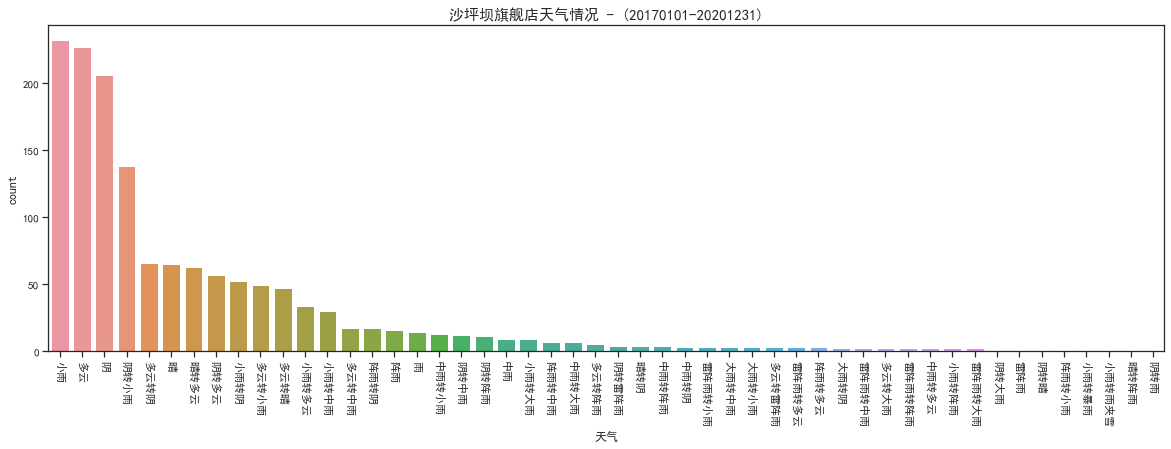

In [526]:
sns.set(font = 'Simhei',style = 'ticks')
f = plt.figure(figsize = (20,6))
sns.countplot(weather.天气, order = weather['天气'].value_counts().index)
plt.xticks(rotation=270)
plt.title('沙坪坝旗舰店天气情况 - (20170101-20201231)', fontsize = 15)

## 人数分布

Text(0.5, 1.0, '沙坪坝旗舰店进店人数分布情况')

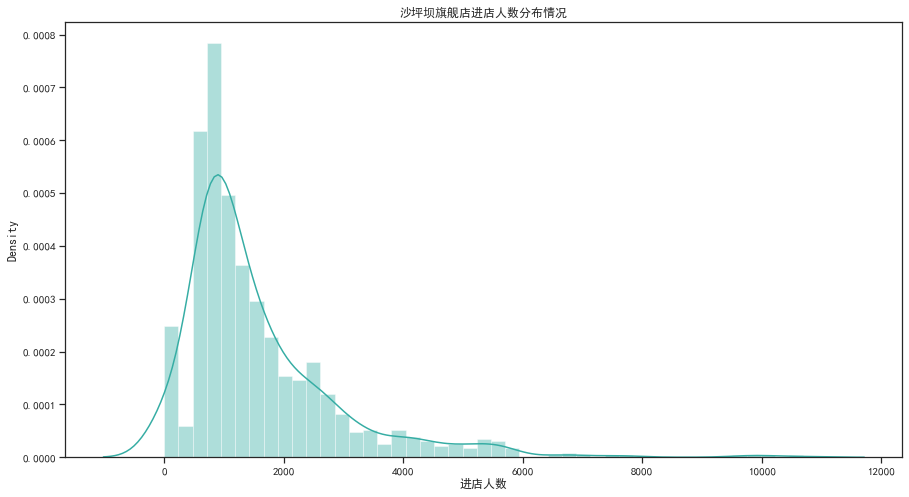

In [447]:
f = plt.figure(figsize = (15,8))
sns.distplot(raw_cus_stm.进店人数, color = sns.color_palette("husl")[3])
plt.title('沙坪坝旗舰店进店人数分布情况')

## 气温变化

<AxesSubplot:title={'center':'沙坪坝旗舰店气温时间趋势'}, xlabel='Date', ylabel='平均温度'>

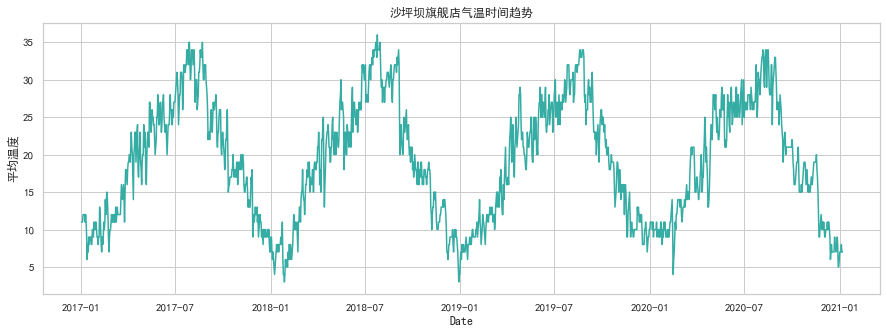

In [525]:
sns.set(style = 'whitegrid', font = 'Simhei')
f = plt.figure(figsize = (15,5))
plt.title('沙坪坝旗舰店气温时间趋势')
sns.lineplot(x = 'Date', y = '平均温度', data = weather, color = sns.color_palette("husl")[3])

## 人数-时间趋势

Text(0.5, 1.0, '沙坪坝旗舰店进店人数 - 时间 趋势')

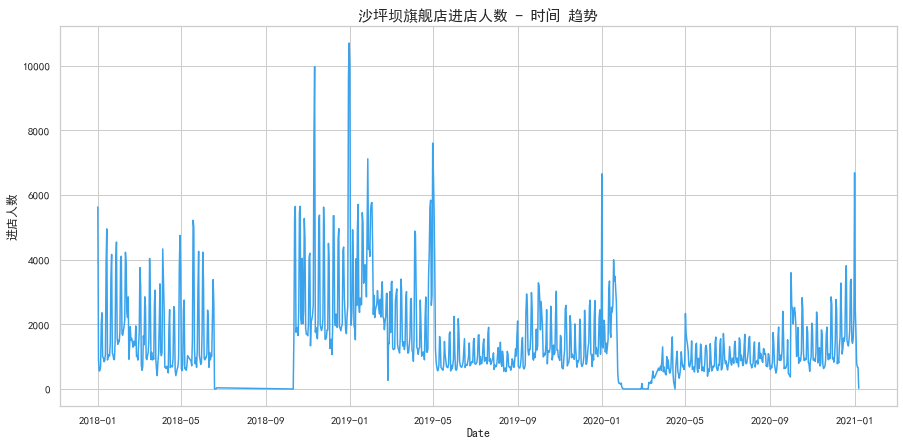

In [466]:
plot_data = raw_cus_stm
plot_data['Date'] = pd.to_datetime(plot_data['日历日(YYYY-MM-DD)'])
f = plt.figure(figsize = (15,7))
sns.lineplot(x = 'Date', y = '进店人数', data = plot_data, color = sns.color_palette("husl")[4])
plt.title('沙坪坝旗舰店进店人数 - 时间 趋势', fontsize = 15)

# Feature Engineering

In [6]:
## feature engineering:
def get_dist(date):
    frt_day = pd.to_datetime(date.year*10000+101, format = '%Y%m%d')
    dist = (date - frt_day).days
    return dist

def feat_eng(input_df):
    # 加入天气
    df = input_df.merge(weather, how = 'left', on = '日历日(YYYY-MM-DD)')
    # 去除气温为空
    df = df[df['平均温度'].notnull()]
    # 加入是否是工作日
    df['is_workday'] = df.Date.apply(is_workday)
    # 年
    df['year'] = df.Date.map(lambda x: x.year)
    # 月
    df['month'] = df.Date.map(lambda x: x.month)
    # 日
    df['day'] = df.Date.map(lambda x: x.day)
    # 一日气温变化
    df['one_day_var'] = abs(df['平均温度'] - df['平均温度'].shift(1))
    # 三日气温变化
    df['three_day_var'] = abs(df['平均温度'] - df['平均温度'].shift(3))
    # 去除空值
    df = df.dropna()
    # 计算距离
    df['dist'] = df.Date.apply(get_dist)
    #df = df.drop(['日历日(YYYY-MM-DD)','门店ID','出店人数','Date','省份','城市','县区','天气'], axis=1)
    #筛选时间
    #df = df[df['Date'] >= pd.to_datetime('2017-01-01')]
    df = df[(df['Date'] <= pd.to_datetime('2019-11-01'))|(df['Date'] >= pd.to_datetime('2020-04-01'))]
    df = df[df['Date'] <= pd.to_datetime('2021-01-06')]    
    #df = df[df.进店人数<=8000]
    
    return df

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

cus_stm = feat_eng(raw_cus_stm)
cus_stm.head(2)
cus_stm.shape

,日历日(YYYY-MM-DD),门店ID,出店人数,进店人数,省份,城市,县区,天气,平均温度,Date,雷,雨,云,阴,晴,雪,is_workday,year,month,day,one_day_var,three_day_var,dist
3,2018-01-04,A00298S473,738,569,重庆,重庆,重庆,小雨转阴,6.0,2018-01-04,False,True,False,True,False,False,True,2018,1,4,1.0,3.0,3
4,2018-01-05,A00298S473,976,692,重庆,重庆,重庆,小雨,7.0,2018-01-05,False,True,False,False,False,False,True,2018,1,5,1.0,2.0,4


(826, 23)

In [7]:
# # 划分数据并建立预测模型
features = cus_stm.drop(['日历日(YYYY-MM-DD)','门店ID','出店人数','Date','省份','城市','县区','天气','进店人数'], axis=1)
target = cus_stm['进店人数']

from sklearn.model_selection import train_test_split

# 将数据切分成训练集和测试集
x_train, x_test,y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 0)

# Training Model

## Model_1

In [8]:
# model_1
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

# training
Model_1 = XGBRegressor(learning_rate=0.1,n_estimators=100,max_depth=8)
start = time.clock()
Model_1.fit(x_train.values,y_train.values,eval_set = [(x_test.values,y_test.values)])
end = time.clock()
print('Model_1 Running time: %s Seconds'%(end-start))

[0]	validation_0-rmse:1927.32971
[1]	validation_0-rmse:1775.89441
[2]	validation_0-rmse:1639.77454
[3]	validation_0-rmse:1516.74268
[4]	validation_0-rmse:1402.94983
[5]	validation_0-rmse:1310.93945
[6]	validation_0-rmse:1233.53931
[7]	validation_0-rmse:1174.23364
[8]	validation_0-rmse:1118.27783
[9]	validation_0-rmse:1075.06287
[10]	validation_0-rmse:1031.61792
[11]	validation_0-rmse:993.96619
[12]	validation_0-rmse:957.70233
[13]	validation_0-rmse:925.55646
[14]	validation_0-rmse:899.79871
[15]	validation_0-rmse:881.08765
[16]	validation_0-rmse:860.12231
[17]	validation_0-rmse:844.46777
[18]	validation_0-rmse:830.04645
[19]	validation_0-rmse:819.62219
[20]	validation_0-rmse:812.00043
[21]	validation_0-rmse:805.57989
[22]	validation_0-rmse:800.74695
[23]	validation_0-rmse:798.38238
[24]	validation_0-rmse:795.55933
[25]	validation_0-rmse:792.26239
[26]	validation_0-rmse:786.60730
[27]	validation_0-rmse:784.19250
[28]	validation_0-rmse:782.22333
[29]	validation_0-rmse:780.74426
[30]	vali

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Model_1 Running time: 5.078277 Seconds


#### Model 1 result & eval

In [9]:
y_pred = Model_1.predict(x_test.values)
Test_Pred = Model_1.predict(features.values)
print("Evaluation Metrics:" )
print('R square: '+str(r2_score(y_test,y_pred)))
print('RMSE After Gradient Desent: 738\n')


print('Whole DF with pred:')
result = cus_stm.drop(['日历日(YYYY-MM-DD)','门店ID','出店人数','省份','城市','县区'], axis=1)
result['f3_model1'] = Test_Pred
result['f3_model1_var'] = result['f3_model1'] - result['进店人数']
result[result['f3_model1_var']>500]


print('Test set with pred')
test_set_result = pd.DataFrame(y_pred)
test_set_result['pred'] = list(y_test)
test_set_result.head(30)

Evaluation Metrics:
R square: 0.6549969227271756
RMSE After Gradient Desent: 738

Whole DF with pred:


,进店人数,天气,平均温度,Date,雷,雨,云,阴,晴,雪,is_workday,year,month,day,one_day_var,three_day_var,dist,f3_model1,f3_model1_var
5,2034,小雨,6.0,2018-01-06,False,True,False,False,False,False,False,2018,1,6,1.0,1.0,5,2711.135254,677.135254
30,1505,多云,5.0,2018-01-31,False,False,True,False,False,False,True,2018,1,31,0.0,1.0,30,2095.191895,590.191895
43,2210,多云转阴,10.0,2018-02-13,False,False,True,True,False,False,True,2018,2,13,2.0,4.0,43,2756.169922,546.169922
52,1478,小雨转多云,7.0,2018-02-22,False,True,True,False,False,False,True,2018,2,22,2.0,3.0,52,2221.332275,743.332275
165,1,阴,26.0,2018-06-19,False,False,False,True,False,False,True,2018,6,19,2.0,0.0,169,610.296570,609.296570
178,1653,小雨,19.0,2018-10-18,False,True,False,False,False,False,True,2018,10,18,0.0,1.0,290,2415.628174,762.628174
243,4280,阴,9.0,2018-12-22,False,False,False,True,False,False,False,2018,12,22,1.0,2.0,355,4870.877930,590.877930
261,1521,阴,7.0,2019-01-09,False,False,False,True,False,False,True,2019,1,9,0.0,0.0,8,3279.987549,1758.987549
266,2561,阴转小雨,7.0,2019-01-14,False,True,False,True,False,False,True,2019,1,14,1.0,1.0,13,3094.904053,533.904053
269,2604,多云转阴,8.0,2019-01-17,False,False,True,True,False,False,True,2019,1,17,0.0,1.0,16,3180.995850,576.995850


Test set with pred


,0,pred
0,909.670227,1070
1,2095.191895,1505
2,1111.473511,1073
3,1469.493164,1313
4,1099.830933,995
5,773.400208,745
6,728.644653,718
7,867.776978,732
8,3523.509521,2557
9,739.933472,722


Text(0.5, 1.0, 'F3M1 Feature Importance Chart')

<AxesSubplot:title={'center':'F3M1 Feature Importance Chart'}>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

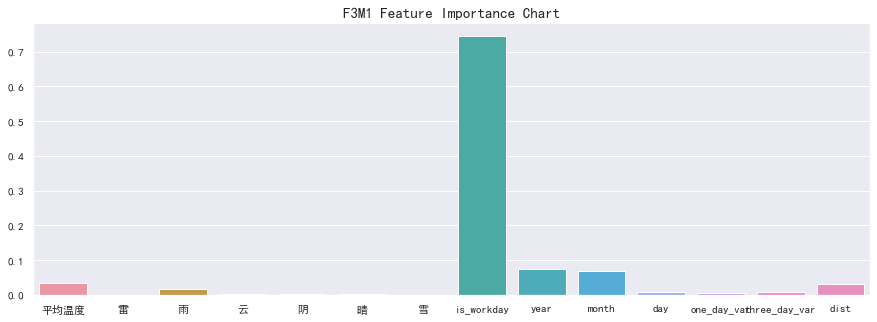

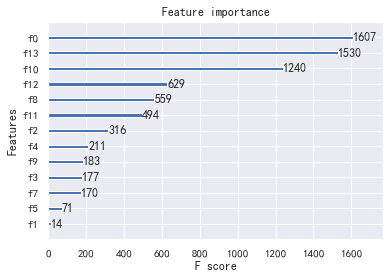

In [342]:
# Feature Importance
f = plt.figure(figsize = (15,5))
plt.title('F3M1 Feature Importance Chart', fontsize = 15)
sns.barplot(x = list(features.columns), y = Model_1.feature_importances_)


from xgboost import plot_importance
plot_importance(Model_1)

## Model_2

In [334]:
# Model_2
Model_2 = XGBRegressor(learning_rate=0.1,n_estimators=100,max_depth=6,min_child_weight = 1,
                     subsample=0.8,colsample_btree=0.8,objective='reg:linear',
                     scale_pos_weight=1,random_state=27)
start=time.clock()
Model_2.fit(x_train.values,y_train.values,eval_set = [(x_test.values,y_test.values)],eval_metric = "rmse",
          early_stopping_rounds = 10)
end=time.clock()
print('Model_2 Running time: %s Seconds'%(end-start))

### make prediction for test data
y_pred = Model_2.predict(x_test.values)
error = rmspe(y_test,y_pred)
print("accuarcy: %.2f%%" % (error*100.0))

[16:24:09] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:24:09] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1930.26807
[1]	validation_0-rmse:1779.78516
[2]	validation_0-rmse:1644.43274
[3]	validation_0-rmse:1526.47009
[4]	validation_0-rmse:1423.00256
[5]	validation_0-rmse:1327.76843
[6]	validation_0-rmse:1242.64831
[7]	validation_0-rmse:1180.89502
[8]	validation_0-rmse:1113.01953
[9]	validation_0-rmse:1056.71472
[10]	validation_0-rmse:1004.26257
[11]	validation_0-rmse:964.46118
[12]	validation_0-rmse:930.23321
[13]	validation_0-rmse:900.34192
[14]	validation_0-rmse:877.69641
[15]	validation_0-rmse:856.79126
[16]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_btree=0.8,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=40,
             num_parallel_tree=1, objective='reg:linear', random_state=27,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

Model_2 Running time: 13.949999999999989 Seconds
accuarcy: 4571.51%


#### Model 2 result & eval

In [335]:
from sklearn.metrics import r2_score
y_pred = Model_2.predict(x_test.values)
Test_Pred = Model_2.predict(features.values)
print("Evaluation Metrics:" )
print('R square: '+str(r2_score(y_test,y_pred)))
print('RMSE After Gradient Desent: 611\n')


print('Whole DF with pred:')
result = cus_stm.drop(['日历日(YYYY-MM-DD)','门店ID','出店人数','省份','城市','县区'], axis=1)
result['f3_model1'] = Test_Pred
result['f3_model1_var'] = result['f3_model1'] - result['进店人数']
result.head()
#result[result['f3_model1_var']< -500]


print('Test set with pred:')
test_set_result = pd.DataFrame(y_pred)
test_set_result['test'] = list(y_test)
test_set_result.columns = ['Pred','Actual']
test_set_result.head()

Evaluation Metrics:
R square: 0.7641749703137974
RMSE After Gradient Desent: 611

Whole DF with pred:


,进店人数,天气,平均温度,Date,雷,雨,云,阴,晴,雪,is_workday,year,month,day,one_day_var,three_day_var,dist,f3_model1,f3_model1_var
3,569,小雨转阴,6.0,2018-01-04,False,True,False,True,False,False,True,2018,1,4,1.0,3.0,3,551.614868,-17.385132
4,692,小雨,7.0,2018-01-05,False,True,False,False,False,False,True,2018,1,5,1.0,2.0,4,478.680176,-213.319824
5,2034,小雨,6.0,2018-01-06,False,True,False,False,False,False,False,2018,1,6,1.0,1.0,5,2547.947998,513.947998
6,2357,小雨,5.0,2018-01-07,False,True,False,False,False,False,False,2018,1,7,1.0,1.0,6,2407.101807,50.101807
7,990,阴转多云,4.0,2018-01-08,False,False,True,True,False,False,True,2018,1,8,1.0,3.0,7,952.294312,-37.705688


Test set with pred:


,Pred,Actual
0,779.849487,1070
1,1875.983643,1505
2,948.125549,1073
3,1518.566895,1313
4,1099.653320,995


Text(0.5, 1.0, 'F3M2 Feature Importance Chart')

<AxesSubplot:title={'center':'F3M2 Feature Importance Chart'}>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

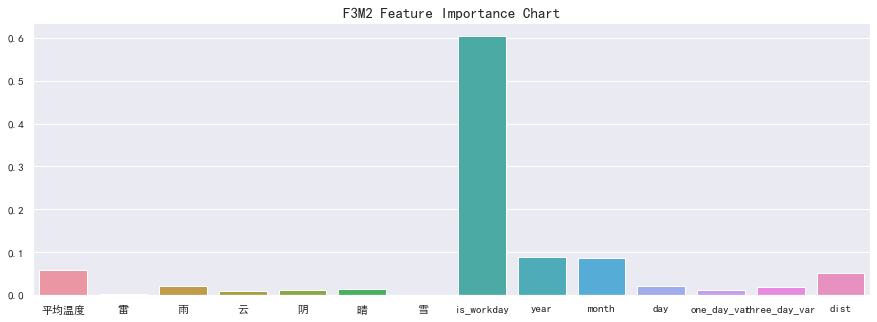

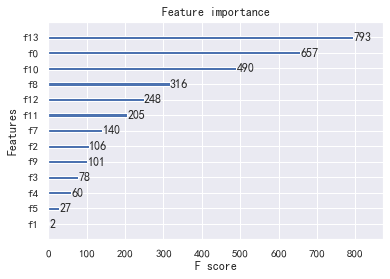

In [343]:
# Feature Importance
f = plt.figure(figsize = (15,5))
plt.title('F3M2 Feature Importance Chart', fontsize = 15)
sns.barplot(x = list(features.columns), y = Model_2.feature_importances_)

from xgboost import plot_importance
plot_importance(Model_2)

## Model_3

In [345]:
# # 网格搜索方法调整模型的最佳参数
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    'min_child_weight':[2,3,4],   
    'colsample_bytree':[0.5,0.7,1],
    'scale_pos_weight':[0.6,0.7,0.8]
}

xlf = XGBRegressor(learning_rate=0.1, n_estimators=100, max_depth=6, min_child_weight = 1,
                     subsample=0.8, colsample_btree=0.8, objective='reg:linear',
                     scale_pos_weight=1,random_state=27)
n_iter_search = 5

gsearch = RandomizedSearchCV(xlf, param_distributions=parameters, n_iter=n_iter_search, cv=2, iid=False)

start=time.clock()
gsearch.fit(x_train.values,y_train.values,eval_set = [(x_test.values,y_test.values)],eval_metric = "rmse",
            early_stopping_rounds = 20)
end=time.clock()
print('RandomSearch Running time: %s Seconds'%(end-start))

print("Best score: %0.3f" % gsearch.best_score_)
best_estimator = gsearch.best_estimator_
print("Best parameters set" )
best_estimator

[16:35:58] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:58] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1940.46362
[1]	validation_0-rmse:1789.73108
[2]	validation_0-rmse:1658.99341
[3]	validation_0-rmse:1542.71033
[4]	validation_0-rmse:1445.13916
[5]	validation_0-rmse:1363.77686
[6]	validation_0-rmse:1287.21155
[7]	validation_0-rmse:1199.53040
[8]	validation_0-rmse:1137.11157
[9]	validation_0-rmse:1080.36328
[10]	validation_0-rmse:1034.54211
[11]	validation_0-rmse:984.60388
[12]	validation_0-rmse:954.58667
[13]	validation_0-rmse:919.25787
[14]	validation_0-rmse:897.43939
[15]	validation_0-rmse:864.98389
[16]	validation_0

[10]	validation_0-rmse:1022.71484
[11]	validation_0-rmse:968.84784
[12]	validation_0-rmse:926.79486
[13]	validation_0-rmse:897.70593
[14]	validation_0-rmse:875.27631
[15]	validation_0-rmse:849.08337
[16]	validation_0-rmse:832.54901
[17]	validation_0-rmse:823.85303
[18]	validation_0-rmse:807.57819
[19]	validation_0-rmse:792.47095
[20]	validation_0-rmse:785.69605
[21]	validation_0-rmse:777.18805
[22]	validation_0-rmse:766.31177
[23]	validation_0-rmse:753.32629
[24]	validation_0-rmse:745.94672
[25]	validation_0-rmse:743.57165
[26]	validation_0-rmse:740.54511
[27]	validation_0-rmse:736.56244
[28]	validation_0-rmse:732.95862
[29]	validation_0-rmse:730.81995
[30]	validation_0-rmse:725.71686
[31]	validation_0-rmse:726.51386
[32]	validation_0-rmse:725.07843
[33]	validation_0-rmse:726.14252
[34]	validation_0-rmse:723.30420
[35]	validation_0-rmse:722.56152
[36]	validation_0-rmse:725.44446
[37]	validation_0-rmse:726.12854
[38]	validation_0-rmse:721.82477
[39]	validation_0-rmse:728.68262
[40]	vali

[81]	validation_0-rmse:721.10126
[82]	validation_0-rmse:721.65747
[83]	validation_0-rmse:721.68982
[84]	validation_0-rmse:720.73114
[85]	validation_0-rmse:721.77448
[86]	validation_0-rmse:721.27606
[87]	validation_0-rmse:721.26489
[88]	validation_0-rmse:721.10675
[16:35:59] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:59] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1942.50476
[1]	validation_0-rmse:1796.77869
[2]	validation_0-rmse:1668.23535
[3]	validation_0-rmse:1564.10107
[4]	validation_0-rmse:1464.50073
[5]	validation_0-rmse:1381.27039
[6]	validation_0-rmse:1304.84668
[7]	validation_0-rmse:1233.20410
[8]	validation_0-r

[1]	validation_0-rmse:1807.28406
[2]	validation_0-rmse:1692.18774
[3]	validation_0-rmse:1580.56555
[4]	validation_0-rmse:1502.71008
[5]	validation_0-rmse:1411.91980
[6]	validation_0-rmse:1339.87134
[7]	validation_0-rmse:1270.72803
[8]	validation_0-rmse:1222.63892
[9]	validation_0-rmse:1169.52686
[10]	validation_0-rmse:1125.74353
[11]	validation_0-rmse:1079.92407
[12]	validation_0-rmse:1035.33106
[13]	validation_0-rmse:997.81708
[14]	validation_0-rmse:964.93012
[15]	validation_0-rmse:935.01068
[16]	validation_0-rmse:915.37616
[17]	validation_0-rmse:889.55872
[18]	validation_0-rmse:869.00793
[19]	validation_0-rmse:860.44336
[20]	validation_0-rmse:848.92914
[21]	validation_0-rmse:848.67999
[22]	validation_0-rmse:840.40576
[23]	validation_0-rmse:827.40820
[24]	validation_0-rmse:819.34821
[25]	validation_0-rmse:812.03906
[26]	validation_0-rmse:807.87122
[27]	validation_0-rmse:805.91693
[28]	validation_0-rmse:803.62451
[29]	validation_0-rmse:801.96600
[30]	validation_0-rmse:797.92779
[31]	va

[45]	validation_0-rmse:807.09448
[46]	validation_0-rmse:806.06055
[47]	validation_0-rmse:810.73663
[48]	validation_0-rmse:812.27533
[49]	validation_0-rmse:811.75171
[50]	validation_0-rmse:807.54254
[51]	validation_0-rmse:810.76324
[52]	validation_0-rmse:812.28491
[53]	validation_0-rmse:810.56567
[54]	validation_0-rmse:809.95966
[55]	validation_0-rmse:812.74383
[56]	validation_0-rmse:812.60266
[57]	validation_0-rmse:809.03802
[58]	validation_0-rmse:812.12073
[59]	validation_0-rmse:810.48309
[60]	validation_0-rmse:811.95911
[61]	validation_0-rmse:809.19220
[62]	validation_0-rmse:810.92749
[63]	validation_0-rmse:811.56018
[64]	validation_0-rmse:812.19855
[65]	validation_0-rmse:814.47864
[66]	validation_0-rmse:813.15430
[16:36:01] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:01] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only 

RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_btree=0.8,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.1,
                                          max_delta_step=None, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          objective='reg:lin

RandomSearch Running time: 124.7399999999999 Seconds
Best score: 0.714
Best parameters set


XGBRegressor(base_score=0.5, booster='gbtree', colsample_btree=0.8,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=40,
             num_parallel_tree=1, objective='reg:linear', random_state=27,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=0.6, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [347]:
Model_3=XGBRegressor(base_score=0.5, booster='gbtree', colsample_btree=0.8,
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
       gamma=0, importance_type='gain', learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=4, missing=None,
       n_estimators=100, n_jobs=40, nthread=None, objective='reg:linear',
       random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.6,
       seed=None, silent=None, subsample=0.8, verbosity=None)

start=time.clock()
Model_3.fit(x_train.values,y_train.values,eval_set = [(x_test.values,y_test.values)],eval_metric = "rmse",
            early_stopping_rounds = 100)
end=time.clock()
print('Model_3 Running time: %s Seconds'%(end-start))



### make prediction for test data
y_pred = Model_3.predict(x_test.values)
error = rmspe(y_test,y_pred)
print("accuarcy: %.2f%%" % (error*100.0))

[16:40:45] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:45] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1927.61194
[1]	validation_0-rmse:1772.32764
[2]	validation_0-rmse:1636.85120
[3]	validation_0-rmse:1520.55798
[4]	validation_0-rmse:1401.27527
[5]	validation_0-rmse:1308.85803
[6]	validation_0-rmse:1218.46155
[7]	validation_0-rmse:1137.55298
[8]	validation_0-rmse:1069.16199
[9]	validation_0-rmse:1007.39252
[10]	validation_0-rmse:958.94916
[11]	validation_0-rmse:908.98193
[12]	validation_0-rmse:870.31348
[13]	validation_0-rmse:839.82050
[14]	validation_0-rmse:807.40057
[15]	validation_0-rmse:790.29761
[16]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_btree=0.8,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=4, missing=None,
             monotone_constraints='()', n_estimators=100, n_jobs=40, nthread=40,
             num_parallel_tree=1, objective='reg:linear', random_state=27,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=0.6, seed=27,
             silent=None, subsample=0.8, tree_method='exact',
             validate_parameters=1, ...)

Model_3 Running time: 15.120000000000005 Seconds
accuarcy: 4117.59%


In [349]:
from sklearn.metrics import r2_score
y_pred = Model_3.predict(x_test.values)
Test_Pred = Model_3.predict(features.values)
print("Evaluation Metrics:" )
print('R square: '+str(r2_score(y_test,y_pred)))
print('RMSE After Gradient Desent: 586\n')


print('Whole DF with pred:')
result = cus_stm.drop(['日历日(YYYY-MM-DD)','门店ID','出店人数','省份','城市','县区'], axis=1)
result['f3_model3'] = Test_Pred
result['f3_model3_var'] = result['f3_model3'] - result['进店人数']
result.head()
#result[result['f3_model1_var']< -500]


print('Test set with pred:')
test_set_result = pd.DataFrame(y_pred)
test_set_result['test'] = list(y_test)
test_set_result.columns = ['Pred','Actual']
test_set_result.head()

Evaluation Metrics:
R square: 0.7827602504714954
RMSE After Gradient Desent: 586

Whole DF with pred:


,进店人数,天气,平均温度,Date,雷,雨,云,阴,晴,雪,is_workday,year,month,day,one_day_var,three_day_var,dist,f3_model3,f3_model3_var
3,569,小雨转阴,6.0,2018-01-04,False,True,False,True,False,False,True,2018,1,4,1.0,3.0,3,741.829590,172.829590
4,692,小雨,7.0,2018-01-05,False,True,False,False,False,False,True,2018,1,5,1.0,2.0,4,141.244385,-550.755615
5,2034,小雨,6.0,2018-01-06,False,True,False,False,False,False,False,2018,1,6,1.0,1.0,5,3057.924072,1023.924072
6,2357,小雨,5.0,2018-01-07,False,True,False,False,False,False,False,2018,1,7,1.0,1.0,6,2711.743652,354.743652
7,990,阴转多云,4.0,2018-01-08,False,False,True,True,False,False,True,2018,1,8,1.0,3.0,7,993.910767,3.910767


Test set with pred:


,Pred,Actual
0,838.654663,1070
1,1476.477905,1505
2,868.735107,1073
3,1353.213013,1313
4,1057.163208,995


## Model_4

### 调参

In [350]:
# 网格搜索法得到的模型精度不高，说明模型精度和n_estimators和max_depth有很紧密的联系，再次选用网格搜索法仅对这两个参数进行选择
parameters = {
    'n_estimators':[100,200,300,400],   
    'max_depth':[5,7,9]  
}

xlf = XGBRegressor(learning_rate=0.1,n_estimators=100,max_depth=6,min_child_weight = 1,
                     subsample=0.8,colsample_btree=0.8,objective='reg:linear',
                     scale_pos_weight=1,random_state=27)
n_iter_search = 5

gsearch = RandomizedSearchCV(xlf,param_distributions=parameters,n_iter=n_iter_search, cv=2, iid=False)

start=time.clock()
gsearch.fit(x_train.values,y_train.values,eval_set = [(x_test.values,y_test.values)],eval_metric = "rmse",
            early_stopping_rounds = 20)
end=time.clock()
print('RandomSearch Running time: %s Seconds'%(end-start))

print("Best score: %0.3f" % gsearch.best_score_)
best_estimator = gsearch.best_estimator_
print("Best parameters set" )
best_estimator

[16:47:23] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:23] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1938.79163
[1]	validation_0-rmse:1799.01880
[2]	validation_0-rmse:1668.72803
[3]	validation_0-rmse:1553.04578
[4]	validation_0-rmse:1454.49475
[5]	validation_0-rmse:1372.80273
[6]	validation_0-rmse:1290.45410
[7]	validation_0-rmse:1214.39771
[8]	validation_0-rmse:1157.03552
[9]	validation_0-rmse:1108.11011
[10]	validation_0-rmse:1058.42578
[11]	validation_0-rmse:1018.14441
[12]	validation_0-rmse:981.42975
[13]	validation_0-rmse:957.41211
[14]	validation_0-rmse:934.54053
[15]	validation_0-rmse:911.98907
[16]	validation_

[65]	validation_0-rmse:816.19293
[66]	validation_0-rmse:816.64520
[67]	validation_0-rmse:815.57159
[68]	validation_0-rmse:815.98529
[69]	validation_0-rmse:815.82690
[70]	validation_0-rmse:815.67731
[71]	validation_0-rmse:815.15930
[72]	validation_0-rmse:815.48584
[73]	validation_0-rmse:814.84949
[74]	validation_0-rmse:815.25140
[75]	validation_0-rmse:815.48566
[76]	validation_0-rmse:815.20221
[77]	validation_0-rmse:815.17865
[78]	validation_0-rmse:814.90808
[79]	validation_0-rmse:815.50836
[80]	validation_0-rmse:815.71643
[81]	validation_0-rmse:815.79852
[82]	validation_0-rmse:815.22028
[83]	validation_0-rmse:815.38367
[84]	validation_0-rmse:815.39056
[85]	validation_0-rmse:815.58313
[86]	validation_0-rmse:815.47473
[87]	validation_0-rmse:815.13275
[88]	validation_0-rmse:814.62659
[89]	validation_0-rmse:814.31006
[90]	validation_0-rmse:814.26025
[91]	validation_0-rmse:813.92999
[92]	validation_0-rmse:813.68976
[93]	validation_0-rmse:813.54804
[94]	validation_0-rmse:813.46893
[95]	valid

[307]	validation_0-rmse:808.26782
[308]	validation_0-rmse:808.26648
[309]	validation_0-rmse:808.26636
[310]	validation_0-rmse:808.26617
[311]	validation_0-rmse:808.26648
[312]	validation_0-rmse:808.26715
[313]	validation_0-rmse:808.26721
[314]	validation_0-rmse:808.26685
[315]	validation_0-rmse:808.26630
[316]	validation_0-rmse:808.26617
[317]	validation_0-rmse:808.26697
[318]	validation_0-rmse:808.26611
[319]	validation_0-rmse:808.26569
[320]	validation_0-rmse:808.26562
[321]	validation_0-rmse:808.26593
[322]	validation_0-rmse:808.26581
[323]	validation_0-rmse:808.26617
[324]	validation_0-rmse:808.26587
[325]	validation_0-rmse:808.26642
[326]	validation_0-rmse:808.26672
[327]	validation_0-rmse:808.26685
[328]	validation_0-rmse:808.26666
[329]	validation_0-rmse:808.26630
[330]	validation_0-rmse:808.26581
[331]	validation_0-rmse:808.26556
[332]	validation_0-rmse:808.26544
[333]	validation_0-rmse:808.26477
[334]	validation_0-rmse:808.26440
[335]	validation_0-rmse:808.26440
[336]	validati

[45]	validation_0-rmse:826.48047
[46]	validation_0-rmse:825.26679
[47]	validation_0-rmse:825.14514
[48]	validation_0-rmse:824.38678
[49]	validation_0-rmse:823.04584
[50]	validation_0-rmse:821.77002
[51]	validation_0-rmse:820.88763
[52]	validation_0-rmse:819.92712
[53]	validation_0-rmse:820.23712
[54]	validation_0-rmse:819.87073
[55]	validation_0-rmse:819.34515
[56]	validation_0-rmse:820.05969
[57]	validation_0-rmse:819.64801
[58]	validation_0-rmse:818.63355
[59]	validation_0-rmse:818.59759
[60]	validation_0-rmse:818.57758
[61]	validation_0-rmse:817.77075
[62]	validation_0-rmse:817.00189
[63]	validation_0-rmse:815.97931
[64]	validation_0-rmse:816.12616
[65]	validation_0-rmse:816.19305
[66]	validation_0-rmse:816.64520
[67]	validation_0-rmse:815.57153
[68]	validation_0-rmse:815.98529
[69]	validation_0-rmse:815.82690
[70]	validation_0-rmse:815.67731
[71]	validation_0-rmse:815.15942
[72]	validation_0-rmse:815.48584
[73]	validation_0-rmse:814.84943
[74]	validation_0-rmse:815.25140
[75]	valid

[59]	validation_0-rmse:817.34070
[60]	validation_0-rmse:816.17041
[61]	validation_0-rmse:815.24377
[62]	validation_0-rmse:816.31927
[63]	validation_0-rmse:815.78241
[64]	validation_0-rmse:815.80585
[65]	validation_0-rmse:816.21063
[66]	validation_0-rmse:817.12366
[67]	validation_0-rmse:817.67645
[68]	validation_0-rmse:818.25446
[69]	validation_0-rmse:817.93317
[70]	validation_0-rmse:817.57416
[71]	validation_0-rmse:817.01099
[72]	validation_0-rmse:817.20782
[73]	validation_0-rmse:817.39368
[74]	validation_0-rmse:816.78534
[75]	validation_0-rmse:817.86847
[76]	validation_0-rmse:817.42364
[77]	validation_0-rmse:816.14642
[78]	validation_0-rmse:815.77551
[79]	validation_0-rmse:816.94556
[80]	validation_0-rmse:817.60925
[16:47:27] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:27] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only 

[0]	validation_0-rmse:1939.18433
[1]	validation_0-rmse:1798.54028
[2]	validation_0-rmse:1671.39404
[3]	validation_0-rmse:1552.46814
[4]	validation_0-rmse:1461.65918
[5]	validation_0-rmse:1383.27991
[6]	validation_0-rmse:1294.86450
[7]	validation_0-rmse:1215.40369
[8]	validation_0-rmse:1156.67590
[9]	validation_0-rmse:1101.84595
[10]	validation_0-rmse:1048.17639
[11]	validation_0-rmse:995.63946
[12]	validation_0-rmse:968.46613
[13]	validation_0-rmse:939.69507
[14]	validation_0-rmse:913.98633
[15]	validation_0-rmse:880.66376
[16]	validation_0-rmse:866.92413
[17]	validation_0-rmse:853.93225
[18]	validation_0-rmse:836.47931
[19]	validation_0-rmse:829.69012
[20]	validation_0-rmse:818.42560
[21]	validation_0-rmse:809.69360
[22]	validation_0-rmse:798.99408
[23]	validation_0-rmse:787.02411
[24]	validation_0-rmse:779.40308
[25]	validation_0-rmse:774.19543
[26]	validation_0-rmse:773.15930
[27]	validation_0-rmse:770.78857
[28]	validation_0-rmse:764.03613
[29]	validation_0-rmse:759.20502
[30]	vali

[84]	validation_0-rmse:819.84680
[16:47:29] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:29] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1928.84924
[1]	validation_0-rmse:1781.10388
[2]	validation_0-rmse:1646.17871
[3]	validation_0-rmse:1527.25488
[4]	validation_0-rmse:1405.82361
[5]	validation_0-rmse:1311.03210
[6]	validation_0-rmse:1224.06909
[7]	validation_0-rmse:1163.16992
[8]	validation_0-rmse:1102.15308
[9]	validation_0-rmse:1050.06897
[10]	validation_0-rmse:999.18640
[11]	validation_0-rmse:954.79724
[12]	validation_0-rmse:921.76569
[13]	validation_0-rmse:884.14069
[14]	validation_0-rmse:854.85492
[15]	validation_0-

RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_btree=0.8,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.1,
                                          max_delta_step=None, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          objective='reg:lin

RandomSearch Running time: 217.72000000000003 Seconds
Best score: 0.700
Best parameters set


XGBRegressor(base_score=0.5, booster='gbtree', colsample_btree=0.8,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=400, n_jobs=40,
             num_parallel_tree=1, objective='reg:linear', random_state=27,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

### run模型

In [351]:
Model_4=XGBRegressor(base_score=0.5, booster='gbtree', colsample_btree=0.8,
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
       gamma=0, importance_type='gain', learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=400, n_jobs=40, nthread=None, objective='reg:linear',
       random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.8, verbosity=1)

start=time.clock()
Model_4.fit(x_train.values,y_train.values,eval_set = [(x_test.values,y_test.values)],eval_metric = "rmse",
            early_stopping_rounds = 100)
end=time.clock()
print('Model4 Running time: %s Seconds'%(end-start))

y_pred = Model_4.predict(x_test.values)
error = rmspe(y_test,y_pred)
print("accuarcy: %.2f%%" % (error*100.0))

print("Make predictions on the test set")
Test_Pred = Model_4.predict(test_new_final.values)

#result = pd.DataFrame({"Id": test_new['Id'], 'Sales':np.expm1(Test_Pred)})
#result.to_csv("Rossmann_submission_Model_4.csv", index=False)

[16:51:58] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:51:58] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1928.84912
[1]	validation_0-rmse:1781.10388
[2]	validation_0-rmse:1646.17859
[3]	validation_0-rmse:1527.25500
[4]	validation_0-rmse:1405.82361
[5]	validation_0-rmse:1311.03210
[6]	validation_0-rmse:1224.06909
[7]	validation_0-rmse:1163.17004
[8]	validation_0-rmse:1102.15308
[9]	validation_0-rmse:1050.06897
[10]	validation_0-rmse:999.18634
[11]	validation_0-rmse:954.79724
[12]	validation_0-rmse:921.76562
[13]	validation_0-rmse:884.14075
[14]	validation_0-rmse:854.85492
[15]	validation_0-rmse:831.98560
[16]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_btree=0.8,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None,
             monotone_constraints='()', n_estimators=400, n_jobs=40, nthread=40,
             num_parallel_tree=1, objective='reg:linear', random_state=27,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
             silent=None, subsample=0.8, tree_method='exact',
             validate_parameters=1, ...)

Model4 Running time: 27.529999999999973 Seconds
accuarcy: 4533.85%
Make predictions on the test set


NameError: name 'test_new_final' is not defined

### 评估

In [352]:
from sklearn.metrics import r2_score
y_pred = Model_4.predict(x_test.values)
Test_Pred = Model_4.predict(features.values)
print("Evaluation Metrics:" )
print('R square: '+str(r2_score(y_test,y_pred)))
print('RMSE After Gradient Desent: 562\n')


print('Whole DF with pred:')
result = cus_stm.drop(['日历日(YYYY-MM-DD)','门店ID','出店人数','省份','城市','县区'], axis=1)
result['f3_model4'] = Test_Pred
result['f3_model4_var'] = result['f3_model4'] - result['进店人数']
result.head()
#result[result['f3_model1_var']< -500]


print('Test set with pred:')
test_set_result = pd.DataFrame(y_pred)
test_set_result['test'] = list(y_test)
test_set_result.columns = ['Pred','Actual']
test_set_result.head()

Evaluation Metrics:
R square: 0.8022327127103863
RMSE After Gradient Desent: 562

Whole DF with pred:


,进店人数,天气,平均温度,Date,雷,雨,云,阴,晴,雪,is_workday,year,month,day,one_day_var,three_day_var,dist,f3_model4,f3_model4_var
3,569,小雨转阴,6.0,2018-01-04,False,True,False,True,False,False,True,2018,1,4,1.0,3.0,3,471.631256,-97.368744
4,692,小雨,7.0,2018-01-05,False,True,False,False,False,False,True,2018,1,5,1.0,2.0,4,491.857941,-200.142059
5,2034,小雨,6.0,2018-01-06,False,True,False,False,False,False,False,2018,1,6,1.0,1.0,5,2661.145752,627.145752
6,2357,小雨,5.0,2018-01-07,False,True,False,False,False,False,False,2018,1,7,1.0,1.0,6,2372.876465,15.876465
7,990,阴转多云,4.0,2018-01-08,False,False,True,True,False,False,True,2018,1,8,1.0,3.0,7,961.456665,-28.543335


Test set with pred:


,Pred,Actual
0,848.014099,1070
1,2252.222900,1505
2,931.220154,1073
3,1447.827881,1313
4,1088.542480,995


## Model_5

### 调参

### 调树深和剪枝

In [356]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

xlf = XGBRegressor(learning_rate=0.1,n_estimators=1000,max_depth=5,min_child_weight = 1,
                     gamma=0, subsample=0.8, colsample_btree=0.8,objective='reg:linear',
                     scale_pos_weight=1,random_state=27)
n_iter_search = 5

gsearch = RandomizedSearchCV(xlf,param_distributions=param_test2,n_iter=n_iter_search, cv=2, iid=False)

start=time.clock()
gsearch.fit(x_train.values,y_train.values,eval_set = [(x_test.values,y_test.values)],eval_metric = "rmse",
            early_stopping_rounds = 20)
end=time.clock()
print('RandomSearch Running time: %s Seconds'%(end-start))

print("Best score: %0.3f" % gsearch.best_score_)
best_estimator = gsearch.best_estimator_
print("Best parameters set" )
best_estimator

[17:05:15] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:05:15] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1940.46375
[1]	validation_0-rmse:1789.60706
[2]	validation_0-rmse:1659.74927
[3]	validation_0-rmse:1541.89124
[4]	validation_0-rmse:1444.46838
[5]	validation_0-rmse:1355.95251
[6]	validation_0-rmse:1275.82654
[7]	validation_0-rmse:1195.34497
[8]	validation_0-rmse:1132.89954
[9]	validation_0-rmse:1075.85278
[10]	validation_0-rmse:1025.38696
[11]	validation_0-rmse:971.12073
[12]	validation_0-rmse:932.17548
[13]	validation_0-rmse:893.16394
[14]	validation_0-rmse:864.78186
[15]	validation_0-rmse:833.03674
[16]	validation_0

[47]	validation_0-rmse:727.18488
[48]	validation_0-rmse:723.70904
[49]	validation_0-rmse:722.72058
[50]	validation_0-rmse:720.65161
[51]	validation_0-rmse:720.51691
[52]	validation_0-rmse:722.23023
[53]	validation_0-rmse:719.63690
[54]	validation_0-rmse:719.85498
[55]	validation_0-rmse:720.70496
[56]	validation_0-rmse:719.13214
[57]	validation_0-rmse:719.79492
[58]	validation_0-rmse:719.68555
[59]	validation_0-rmse:718.95758
[60]	validation_0-rmse:718.48145
[61]	validation_0-rmse:720.82434
[62]	validation_0-rmse:720.91949
[63]	validation_0-rmse:719.42633
[64]	validation_0-rmse:717.82837
[65]	validation_0-rmse:719.06128
[66]	validation_0-rmse:717.91223
[67]	validation_0-rmse:717.65704
[68]	validation_0-rmse:716.62012
[69]	validation_0-rmse:715.43323
[70]	validation_0-rmse:713.18268
[71]	validation_0-rmse:711.93439
[72]	validation_0-rmse:711.65277
[73]	validation_0-rmse:711.07935
[74]	validation_0-rmse:711.20880
[75]	validation_0-rmse:711.71069
[76]	validation_0-rmse:711.41540
[77]	valid

[57]	validation_0-rmse:705.62994
[58]	validation_0-rmse:705.49597
[59]	validation_0-rmse:705.25800
[60]	validation_0-rmse:704.83679
[61]	validation_0-rmse:707.60346
[62]	validation_0-rmse:707.86865
[63]	validation_0-rmse:707.05286
[64]	validation_0-rmse:705.17993
[65]	validation_0-rmse:703.97644
[66]	validation_0-rmse:703.40381
[67]	validation_0-rmse:701.38849
[17:05:17] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:05:17] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1941.15527
[1]	validation_0-rmse:1796.53577
[2]	validation_0-rmse:1668.25684
[3]	validation_0-rmse:1557.30164
[4]	validation_0-rmse:1456.53162
[5]	validation_0-r

[18]	validation_0-rmse:867.32452
[19]	validation_0-rmse:863.45691
[20]	validation_0-rmse:852.98370
[21]	validation_0-rmse:843.35590
[22]	validation_0-rmse:840.18433
[23]	validation_0-rmse:836.98749
[24]	validation_0-rmse:836.33746
[25]	validation_0-rmse:828.31726
[26]	validation_0-rmse:818.79828
[27]	validation_0-rmse:817.75873
[28]	validation_0-rmse:809.39654
[29]	validation_0-rmse:805.69006
[30]	validation_0-rmse:801.96570
[31]	validation_0-rmse:797.45587
[32]	validation_0-rmse:795.69519
[33]	validation_0-rmse:795.78827
[34]	validation_0-rmse:791.66467
[35]	validation_0-rmse:788.52728
[36]	validation_0-rmse:783.19208
[37]	validation_0-rmse:776.60510
[38]	validation_0-rmse:773.47174
[39]	validation_0-rmse:770.36005
[40]	validation_0-rmse:771.27332
[41]	validation_0-rmse:772.20972
[42]	validation_0-rmse:764.93732
[43]	validation_0-rmse:763.27411
[44]	validation_0-rmse:760.25269
[45]	validation_0-rmse:763.06561
[46]	validation_0-rmse:759.07178
[47]	validation_0-rmse:762.76556
[48]	valid

[1]	validation_0-rmse:1794.53284
[2]	validation_0-rmse:1668.81848
[3]	validation_0-rmse:1568.48987
[4]	validation_0-rmse:1466.80713
[5]	validation_0-rmse:1374.33386
[6]	validation_0-rmse:1300.12415
[7]	validation_0-rmse:1238.17273
[8]	validation_0-rmse:1178.30481
[9]	validation_0-rmse:1127.80640
[10]	validation_0-rmse:1079.65796
[11]	validation_0-rmse:1045.09204
[12]	validation_0-rmse:1016.11957
[13]	validation_0-rmse:978.30164
[14]	validation_0-rmse:952.90381
[15]	validation_0-rmse:933.70715
[16]	validation_0-rmse:909.19098
[17]	validation_0-rmse:894.21503
[18]	validation_0-rmse:879.24481
[19]	validation_0-rmse:871.66553
[20]	validation_0-rmse:866.28363
[21]	validation_0-rmse:857.45227
[22]	validation_0-rmse:854.58545
[23]	validation_0-rmse:853.49457
[24]	validation_0-rmse:853.16785
[25]	validation_0-rmse:848.04736
[26]	validation_0-rmse:842.01831
[27]	validation_0-rmse:832.51086
[28]	validation_0-rmse:823.52631
[29]	validation_0-rmse:822.84711
[30]	validation_0-rmse:826.06940
[31]	va

[150]	validation_0-rmse:569.94543
[151]	validation_0-rmse:569.27936
[152]	validation_0-rmse:568.39667
[153]	validation_0-rmse:567.62732
[154]	validation_0-rmse:566.95184
[155]	validation_0-rmse:566.95233
[156]	validation_0-rmse:568.68524
[157]	validation_0-rmse:568.51062
[158]	validation_0-rmse:567.68927
[159]	validation_0-rmse:566.97467
[160]	validation_0-rmse:566.02008
[161]	validation_0-rmse:566.60321
[162]	validation_0-rmse:566.26251
[163]	validation_0-rmse:566.39398
[164]	validation_0-rmse:566.67810
[165]	validation_0-rmse:566.41687
[166]	validation_0-rmse:566.72882
[167]	validation_0-rmse:566.09058
[168]	validation_0-rmse:565.49475
[169]	validation_0-rmse:565.44373
[170]	validation_0-rmse:565.08856
[171]	validation_0-rmse:565.15241
[172]	validation_0-rmse:564.67212
[173]	validation_0-rmse:564.44714
[174]	validation_0-rmse:564.98199
[175]	validation_0-rmse:564.50073
[176]	validation_0-rmse:564.08704
[177]	validation_0-rmse:563.30408
[178]	validation_0-rmse:563.77356
[179]	validati

RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_btree=0.8,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=0,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.1,
                                          max_delta_step=None, max_depth=5,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=1000, n_jobs=None,
                                          num_parallel_tree=None,
                                          objective='reg:linea

RandomSearch Running time: 138.51999999999987 Seconds
Best score: 0.714
Best parameters set


XGBRegressor(base_score=0.5, booster='gbtree', colsample_btree=0.8,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=40,
             num_parallel_tree=1, objective='reg:linear', random_state=27,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [359]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

xlf = XGBRegressor(learning_rate=0.1,n_estimators=1000,max_depth=5,min_child_weight = 1,
                     gamma=0, subsample=0.8, colsample_btree=0.8,objective='reg:linear',
                     scale_pos_weight=1,random_state=27)
n_iter_search = 5

gsearch = RandomizedSearchCV(xlf,param_distributions=param_test1,n_iter=n_iter_search, cv=2, iid=False)

start=time.clock()
gsearch.fit(x_train.values,y_train.values,eval_set = [(x_test.values,y_test.values)],eval_metric = "rmse",
            early_stopping_rounds = 20)
end=time.clock()
print('RandomSearch Running time: %s Seconds'%(end-start))

print("Best score: %0.3f" % gsearch.best_score_)
best_estimator = gsearch.best_estimator_
print("Best parameters set" )
best_estimator

[17:09:43] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:09:43] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1940.46387
[1]	validation_0-rmse:1789.87817
[2]	validation_0-rmse:1659.82715
[3]	validation_0-rmse:1543.37744
[4]	validation_0-rmse:1446.15820
[5]	validation_0-rmse:1359.58362
[6]	validation_0-rmse:1279.10693
[7]	validation_0-rmse:1199.07886
[8]	validation_0-rmse:1135.10596
[9]	validation_0-rmse:1085.44019
[10]	validation_0-rmse:1036.39136
[11]	validation_0-rmse:987.02405
[12]	validation_0-rmse:954.59247
[13]	validation_0-rmse:926.91681
[14]	validation_0-rmse:898.56030
[15]	validation_0-rmse:871.36743
[16]	validation_0

[28]	validation_0-rmse:764.53156
[29]	validation_0-rmse:761.52191
[30]	validation_0-rmse:757.64600
[31]	validation_0-rmse:755.48016
[32]	validation_0-rmse:755.31903
[33]	validation_0-rmse:754.31055
[34]	validation_0-rmse:749.35168
[35]	validation_0-rmse:745.80316
[36]	validation_0-rmse:751.35046
[37]	validation_0-rmse:747.95422
[38]	validation_0-rmse:744.00891
[39]	validation_0-rmse:745.62091
[40]	validation_0-rmse:745.52118
[41]	validation_0-rmse:743.88202
[42]	validation_0-rmse:743.78625
[43]	validation_0-rmse:744.43372
[44]	validation_0-rmse:743.81158
[45]	validation_0-rmse:742.80786
[46]	validation_0-rmse:741.16669
[47]	validation_0-rmse:738.16034
[48]	validation_0-rmse:737.97082
[49]	validation_0-rmse:737.85480
[50]	validation_0-rmse:736.53137
[51]	validation_0-rmse:736.83588
[52]	validation_0-rmse:735.48816
[53]	validation_0-rmse:734.92804
[54]	validation_0-rmse:733.58148
[55]	validation_0-rmse:734.61597
[56]	validation_0-rmse:733.22040
[57]	validation_0-rmse:734.47632
[58]	valid

[30]	validation_0-rmse:727.97272
[31]	validation_0-rmse:727.76953
[32]	validation_0-rmse:727.76483
[33]	validation_0-rmse:724.03381
[34]	validation_0-rmse:722.03430
[35]	validation_0-rmse:721.00623
[36]	validation_0-rmse:721.08173
[37]	validation_0-rmse:714.78937
[38]	validation_0-rmse:711.91272
[39]	validation_0-rmse:713.75714
[40]	validation_0-rmse:712.56982
[41]	validation_0-rmse:710.30017
[42]	validation_0-rmse:711.45319
[43]	validation_0-rmse:714.62561
[44]	validation_0-rmse:716.35382
[45]	validation_0-rmse:713.99890
[46]	validation_0-rmse:715.29419
[47]	validation_0-rmse:714.57788
[48]	validation_0-rmse:710.86023
[49]	validation_0-rmse:710.09784
[50]	validation_0-rmse:707.51526
[51]	validation_0-rmse:706.27429
[52]	validation_0-rmse:705.07794
[53]	validation_0-rmse:703.85242
[54]	validation_0-rmse:704.22699
[55]	validation_0-rmse:704.20172
[56]	validation_0-rmse:704.43829
[57]	validation_0-rmse:706.25531
[58]	validation_0-rmse:706.02655
[59]	validation_0-rmse:707.12970
[60]	valid

[94]	validation_0-rmse:720.43939
[95]	validation_0-rmse:720.46429
[96]	validation_0-rmse:720.34015
[97]	validation_0-rmse:720.39477
[98]	validation_0-rmse:720.17535
[99]	validation_0-rmse:719.89325
[100]	validation_0-rmse:720.01526
[101]	validation_0-rmse:720.06036
[102]	validation_0-rmse:719.96185
[103]	validation_0-rmse:720.58783
[104]	validation_0-rmse:719.84137
[105]	validation_0-rmse:719.92419
[106]	validation_0-rmse:718.98413
[107]	validation_0-rmse:718.67676
[108]	validation_0-rmse:717.98261
[109]	validation_0-rmse:717.81397
[110]	validation_0-rmse:717.60889
[111]	validation_0-rmse:716.93957
[112]	validation_0-rmse:716.65710
[113]	validation_0-rmse:716.54547
[114]	validation_0-rmse:716.59393
[115]	validation_0-rmse:716.42163
[116]	validation_0-rmse:716.57513
[117]	validation_0-rmse:716.34344
[118]	validation_0-rmse:716.69946
[119]	validation_0-rmse:716.10358
[120]	validation_0-rmse:716.01971
[121]	validation_0-rmse:717.01221
[122]	validation_0-rmse:716.56006
[123]	validation_0-r

[13]	validation_0-rmse:920.59314
[14]	validation_0-rmse:903.00568
[15]	validation_0-rmse:872.96008
[16]	validation_0-rmse:852.65088
[17]	validation_0-rmse:840.06622
[18]	validation_0-rmse:818.85413
[19]	validation_0-rmse:811.72699
[20]	validation_0-rmse:801.32587
[21]	validation_0-rmse:793.01752
[22]	validation_0-rmse:783.90234
[23]	validation_0-rmse:770.23859
[24]	validation_0-rmse:763.48206
[25]	validation_0-rmse:763.72797
[26]	validation_0-rmse:755.08215
[27]	validation_0-rmse:747.28687
[28]	validation_0-rmse:742.19977
[29]	validation_0-rmse:739.75250
[30]	validation_0-rmse:735.23987
[31]	validation_0-rmse:736.01611
[32]	validation_0-rmse:735.09808
[33]	validation_0-rmse:732.22852
[34]	validation_0-rmse:729.99023
[35]	validation_0-rmse:729.34198
[36]	validation_0-rmse:729.31268
[37]	validation_0-rmse:719.89746
[38]	validation_0-rmse:716.35394
[39]	validation_0-rmse:712.74097
[40]	validation_0-rmse:710.14166
[41]	validation_0-rmse:709.22241
[42]	validation_0-rmse:710.30096
[43]	valid

[86]	validation_0-rmse:587.12884
[87]	validation_0-rmse:586.18457
[88]	validation_0-rmse:586.24249
[89]	validation_0-rmse:586.40936
[90]	validation_0-rmse:585.29999
[91]	validation_0-rmse:585.50507
[92]	validation_0-rmse:586.40619
[93]	validation_0-rmse:586.63251
[94]	validation_0-rmse:586.15997
[95]	validation_0-rmse:584.64099
[96]	validation_0-rmse:582.15118
[97]	validation_0-rmse:581.11133
[98]	validation_0-rmse:581.52008
[99]	validation_0-rmse:580.36529
[100]	validation_0-rmse:579.34680
[101]	validation_0-rmse:578.78766
[102]	validation_0-rmse:576.85413
[103]	validation_0-rmse:576.71588
[104]	validation_0-rmse:575.97589
[105]	validation_0-rmse:576.71606
[106]	validation_0-rmse:576.18872
[107]	validation_0-rmse:575.49554
[108]	validation_0-rmse:575.32184
[109]	validation_0-rmse:574.46289
[110]	validation_0-rmse:573.62189
[111]	validation_0-rmse:574.02344
[112]	validation_0-rmse:573.16406
[113]	validation_0-rmse:572.64471
[114]	validation_0-rmse:571.80518
[115]	validation_0-rmse:571.

RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_btree=0.8,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=0,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.1,
                                          max_delta_step=None, max_depth=5,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=1000, n_jobs=None,
                                          num_parallel_tree=None,
                                          objective='reg:linea

RandomSearch Running time: 164.01 Seconds
Best score: 0.712
Best parameters set


XGBRegressor(base_score=0.5, booster='gbtree', colsample_btree=0.8,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=40,
             num_parallel_tree=1, objective='reg:linear', random_state=27,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

### 调gamma

In [361]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

xlf = XGBRegressor(learning_rate=0.1,n_estimators=1000,max_depth=7,min_child_weight = 5,
                     gamma=0, subsample=0.8, colsample_btree=0.8,objective='reg:linear',
                     scale_pos_weight=1,random_state=27)
n_iter_search = 5

gsearch = RandomizedSearchCV(xlf,param_distributions=param_test3,n_iter=n_iter_search, cv=5, iid=False)

start=time.clock()
gsearch.fit(x_train.values,y_train.values,eval_set = [(x_test.values,y_test.values)],eval_metric = "rmse",
            early_stopping_rounds = 20)
end=time.clock()
print('RandomSearch Running time: %s Seconds'%(end-start))

print("Best score: %0.3f" % gsearch.best_score_)
best_estimator = gsearch.best_estimator_
print("Best parameters set" )
best_estimator

[17:13:36] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:36] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1930.57153
[1]	validation_0-rmse:1785.41113
[2]	validation_0-rmse:1647.43799
[3]	validation_0-rmse:1525.21240
[4]	validation_0-rmse:1416.41125
[5]	validation_0-rmse:1321.36951
[6]	validation_0-rmse:1237.59216
[7]	validation_0-rmse:1162.08435
[8]	validation_0-rmse:1093.36377
[9]	validation_0-rmse:1033.09155
[10]	validation_0-rmse:985.25629
[11]	validation_0-rmse:940.58960
[12]	validation_0-rmse:899.81665
[13]	validation_0-rmse:871.19708
[14]	validation_0-rmse:847.18085
[15]	validation_0-rmse:818.62671
[16]	validation_0-

[231]	validation_0-rmse:603.02588
[232]	validation_0-rmse:603.16345
[233]	validation_0-rmse:602.90167
[234]	validation_0-rmse:602.53180
[235]	validation_0-rmse:602.45355
[236]	validation_0-rmse:602.22827
[237]	validation_0-rmse:602.26575
[238]	validation_0-rmse:602.61450
[239]	validation_0-rmse:602.45642
[240]	validation_0-rmse:602.33661
[241]	validation_0-rmse:602.94812
[242]	validation_0-rmse:603.02698
[243]	validation_0-rmse:603.19263
[244]	validation_0-rmse:603.12164
[245]	validation_0-rmse:602.97577
[246]	validation_0-rmse:603.05585
[247]	validation_0-rmse:603.27448
[248]	validation_0-rmse:603.07300
[249]	validation_0-rmse:603.04138
[250]	validation_0-rmse:602.95911
[251]	validation_0-rmse:602.73370
[252]	validation_0-rmse:602.41974
[253]	validation_0-rmse:602.26050
[254]	validation_0-rmse:602.25586
[255]	validation_0-rmse:602.23712
[256]	validation_0-rmse:601.98608
[257]	validation_0-rmse:602.08917
[258]	validation_0-rmse:602.08582
[259]	validation_0-rmse:602.11127
[260]	validati

[171]	validation_0-rmse:627.86078
[172]	validation_0-rmse:628.52313
[173]	validation_0-rmse:628.19165
[174]	validation_0-rmse:628.94092
[175]	validation_0-rmse:629.17517
[176]	validation_0-rmse:629.38824
[177]	validation_0-rmse:629.77020
[178]	validation_0-rmse:629.31366
[179]	validation_0-rmse:628.91266
[180]	validation_0-rmse:628.82117
[181]	validation_0-rmse:628.63251
[182]	validation_0-rmse:628.32593
[183]	validation_0-rmse:627.59747
[17:13:38] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:38] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1928.78345
[1]	validation_0-rmse:1775.92407
[2]	validation_0-rmse:1638.14954
[3]	v

[28]	validation_0-rmse:734.49237
[29]	validation_0-rmse:734.94940
[30]	validation_0-rmse:737.57684
[31]	validation_0-rmse:738.17407
[32]	validation_0-rmse:737.47693
[33]	validation_0-rmse:733.90588
[34]	validation_0-rmse:737.37109
[35]	validation_0-rmse:736.60113
[36]	validation_0-rmse:733.03064
[37]	validation_0-rmse:730.20599
[38]	validation_0-rmse:728.41754
[39]	validation_0-rmse:727.09436
[40]	validation_0-rmse:725.97217
[41]	validation_0-rmse:724.75586
[42]	validation_0-rmse:723.93127
[43]	validation_0-rmse:724.58392
[44]	validation_0-rmse:722.97162
[45]	validation_0-rmse:720.76044
[46]	validation_0-rmse:721.29724
[47]	validation_0-rmse:721.30231
[48]	validation_0-rmse:722.68317
[49]	validation_0-rmse:722.82587
[50]	validation_0-rmse:721.92835
[51]	validation_0-rmse:721.76386
[52]	validation_0-rmse:719.74872
[53]	validation_0-rmse:718.90869
[54]	validation_0-rmse:716.43689
[55]	validation_0-rmse:718.98425
[56]	validation_0-rmse:720.30750
[57]	validation_0-rmse:721.16687
[58]	valid

[172]	validation_0-rmse:582.92792
[173]	validation_0-rmse:582.18732
[174]	validation_0-rmse:581.87830
[175]	validation_0-rmse:582.19592
[176]	validation_0-rmse:581.75244
[177]	validation_0-rmse:581.04980
[178]	validation_0-rmse:581.52008
[179]	validation_0-rmse:580.94482
[180]	validation_0-rmse:581.07648
[181]	validation_0-rmse:580.30731
[182]	validation_0-rmse:580.86548
[183]	validation_0-rmse:580.13648
[184]	validation_0-rmse:580.29053
[185]	validation_0-rmse:579.31867
[186]	validation_0-rmse:579.33014
[187]	validation_0-rmse:579.94556
[188]	validation_0-rmse:580.11902
[189]	validation_0-rmse:580.02325
[190]	validation_0-rmse:579.81915
[191]	validation_0-rmse:580.38928
[192]	validation_0-rmse:579.63287
[193]	validation_0-rmse:578.57996
[194]	validation_0-rmse:578.96027
[195]	validation_0-rmse:578.26587
[196]	validation_0-rmse:578.64276
[197]	validation_0-rmse:578.03430
[198]	validation_0-rmse:578.84833
[199]	validation_0-rmse:578.23700
[200]	validation_0-rmse:577.02508
[201]	validati

[179]	validation_0-rmse:606.23120
[180]	validation_0-rmse:606.41644
[181]	validation_0-rmse:606.94391
[182]	validation_0-rmse:606.72461
[183]	validation_0-rmse:606.57593
[184]	validation_0-rmse:606.37549
[185]	validation_0-rmse:606.85187
[186]	validation_0-rmse:606.80792
[187]	validation_0-rmse:606.90637
[188]	validation_0-rmse:606.45605
[189]	validation_0-rmse:606.43957
[190]	validation_0-rmse:606.19714
[191]	validation_0-rmse:605.42023
[192]	validation_0-rmse:605.39996
[193]	validation_0-rmse:605.30206
[194]	validation_0-rmse:604.79608
[195]	validation_0-rmse:605.19989
[196]	validation_0-rmse:605.02338
[197]	validation_0-rmse:605.01410
[198]	validation_0-rmse:604.66852
[199]	validation_0-rmse:604.39917
[200]	validation_0-rmse:604.48877
[201]	validation_0-rmse:604.63208
[202]	validation_0-rmse:604.89954
[203]	validation_0-rmse:604.48071
[204]	validation_0-rmse:604.93292
[205]	validation_0-rmse:604.71716
[206]	validation_0-rmse:604.78387
[207]	validation_0-rmse:604.78247
[208]	validati

[118]	validation_0-rmse:639.07068
[119]	validation_0-rmse:638.37408
[120]	validation_0-rmse:636.93976
[121]	validation_0-rmse:635.45813
[122]	validation_0-rmse:635.46301
[123]	validation_0-rmse:634.54645
[124]	validation_0-rmse:633.67719
[125]	validation_0-rmse:635.32593
[126]	validation_0-rmse:636.07611
[127]	validation_0-rmse:635.01459
[128]	validation_0-rmse:636.18201
[129]	validation_0-rmse:637.07025
[130]	validation_0-rmse:637.65204
[131]	validation_0-rmse:636.21985
[132]	validation_0-rmse:635.00629
[133]	validation_0-rmse:633.74939
[134]	validation_0-rmse:634.18854
[135]	validation_0-rmse:634.55719
[136]	validation_0-rmse:633.75610
[137]	validation_0-rmse:633.53601
[138]	validation_0-rmse:633.61890
[139]	validation_0-rmse:633.45398
[140]	validation_0-rmse:634.25555
[141]	validation_0-rmse:634.19989
[142]	validation_0-rmse:635.20557
[143]	validation_0-rmse:635.17340
[144]	validation_0-rmse:634.43005
[145]	validation_0-rmse:634.58142
[146]	validation_0-rmse:634.88879
[147]	validati

[165]	validation_0-rmse:631.56793
[166]	validation_0-rmse:632.01739
[167]	validation_0-rmse:632.59137
[168]	validation_0-rmse:631.41602
[169]	validation_0-rmse:631.14600
[170]	validation_0-rmse:631.41009
[171]	validation_0-rmse:630.90619
[172]	validation_0-rmse:630.91669
[173]	validation_0-rmse:630.05585
[174]	validation_0-rmse:630.88452
[175]	validation_0-rmse:630.93933
[176]	validation_0-rmse:631.45227
[17:13:42] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:42] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1934.03247
[1]	validation_0-rmse:1790.94739
[2]	validation_0-rmse:1661.52576
[3]	validation_0-rmse:1545.08154
[4]	va

[119]	validation_0-rmse:592.43658
[120]	validation_0-rmse:593.53778
[121]	validation_0-rmse:593.54315
[122]	validation_0-rmse:594.02356
[123]	validation_0-rmse:594.59851
[124]	validation_0-rmse:593.92554
[125]	validation_0-rmse:593.54816
[126]	validation_0-rmse:593.05774
[127]	validation_0-rmse:591.53967
[128]	validation_0-rmse:593.31598
[129]	validation_0-rmse:594.58429
[130]	validation_0-rmse:595.26050
[131]	validation_0-rmse:593.57452
[132]	validation_0-rmse:591.79321
[133]	validation_0-rmse:591.15472
[134]	validation_0-rmse:589.72485
[135]	validation_0-rmse:588.84522
[136]	validation_0-rmse:587.54034
[137]	validation_0-rmse:588.78912
[138]	validation_0-rmse:588.60461
[139]	validation_0-rmse:587.53082
[140]	validation_0-rmse:587.36365
[141]	validation_0-rmse:586.29456
[142]	validation_0-rmse:586.88886
[143]	validation_0-rmse:586.67151
[144]	validation_0-rmse:585.80353
[145]	validation_0-rmse:584.67035
[146]	validation_0-rmse:585.41193
[147]	validation_0-rmse:585.85376
[148]	validati

[125]	validation_0-rmse:617.74628
[126]	validation_0-rmse:617.51135
[127]	validation_0-rmse:617.23254
[128]	validation_0-rmse:617.68463
[129]	validation_0-rmse:618.24744
[130]	validation_0-rmse:617.31043
[131]	validation_0-rmse:617.37610
[132]	validation_0-rmse:616.47925
[133]	validation_0-rmse:616.24731
[134]	validation_0-rmse:615.83472
[135]	validation_0-rmse:614.45770
[136]	validation_0-rmse:613.76227
[137]	validation_0-rmse:613.74841
[138]	validation_0-rmse:613.86932
[139]	validation_0-rmse:613.89502
[140]	validation_0-rmse:613.34406
[141]	validation_0-rmse:613.09747
[142]	validation_0-rmse:612.98175
[143]	validation_0-rmse:612.54602
[144]	validation_0-rmse:613.11365
[145]	validation_0-rmse:611.98981
[146]	validation_0-rmse:611.81323
[147]	validation_0-rmse:611.14893
[148]	validation_0-rmse:611.03394
[149]	validation_0-rmse:610.31836
[150]	validation_0-rmse:610.16663
[151]	validation_0-rmse:610.46033
[152]	validation_0-rmse:611.03363
[153]	validation_0-rmse:611.23242
[154]	validati

[63]	validation_0-rmse:651.87085
[64]	validation_0-rmse:650.47461
[65]	validation_0-rmse:651.01257
[66]	validation_0-rmse:649.99707
[67]	validation_0-rmse:646.96832
[68]	validation_0-rmse:649.78131
[69]	validation_0-rmse:649.82611
[70]	validation_0-rmse:652.13629
[71]	validation_0-rmse:650.65265
[72]	validation_0-rmse:650.96973
[73]	validation_0-rmse:648.82050
[74]	validation_0-rmse:649.03754
[75]	validation_0-rmse:651.77258
[76]	validation_0-rmse:652.87695
[77]	validation_0-rmse:654.75897
[78]	validation_0-rmse:651.81403
[79]	validation_0-rmse:650.71698
[80]	validation_0-rmse:650.34631
[81]	validation_0-rmse:652.03717
[82]	validation_0-rmse:654.47589
[83]	validation_0-rmse:652.32660
[84]	validation_0-rmse:651.74652
[85]	validation_0-rmse:649.02234
[86]	validation_0-rmse:648.93860
[87]	validation_0-rmse:646.43109
[88]	validation_0-rmse:645.55853
[89]	validation_0-rmse:644.00043
[90]	validation_0-rmse:645.51263
[91]	validation_0-rmse:644.66699
[92]	validation_0-rmse:644.15533
[93]	valid

[110]	validation_0-rmse:640.67767
[111]	validation_0-rmse:639.88336
[112]	validation_0-rmse:639.15308
[113]	validation_0-rmse:640.71100
[114]	validation_0-rmse:640.14069
[115]	validation_0-rmse:638.56445
[116]	validation_0-rmse:638.07239
[117]	validation_0-rmse:636.83588
[118]	validation_0-rmse:637.14081
[119]	validation_0-rmse:636.24023
[120]	validation_0-rmse:637.07434
[121]	validation_0-rmse:637.33032
[122]	validation_0-rmse:636.24182
[123]	validation_0-rmse:637.33313
[124]	validation_0-rmse:636.75690
[125]	validation_0-rmse:636.42835
[126]	validation_0-rmse:636.30609
[127]	validation_0-rmse:636.62372
[128]	validation_0-rmse:637.97418
[129]	validation_0-rmse:638.62201
[130]	validation_0-rmse:638.82770
[131]	validation_0-rmse:638.38196
[132]	validation_0-rmse:637.65491
[133]	validation_0-rmse:637.14166
[134]	validation_0-rmse:636.85535
[135]	validation_0-rmse:637.32709
[136]	validation_0-rmse:636.53406
[137]	validation_0-rmse:638.30395
[138]	validation_0-rmse:637.20636
[139]	validati

[63]	validation_0-rmse:627.65332
[64]	validation_0-rmse:625.25684
[65]	validation_0-rmse:626.13946
[66]	validation_0-rmse:623.62738
[67]	validation_0-rmse:619.03827
[68]	validation_0-rmse:620.16602
[69]	validation_0-rmse:622.14948
[70]	validation_0-rmse:619.84277
[71]	validation_0-rmse:617.81329
[72]	validation_0-rmse:616.56012
[73]	validation_0-rmse:616.02222
[74]	validation_0-rmse:615.24500
[75]	validation_0-rmse:613.96344
[76]	validation_0-rmse:614.59918
[77]	validation_0-rmse:612.36963
[78]	validation_0-rmse:609.14880
[79]	validation_0-rmse:612.34955
[80]	validation_0-rmse:612.09784
[81]	validation_0-rmse:609.03662
[82]	validation_0-rmse:608.77570
[83]	validation_0-rmse:609.56024
[84]	validation_0-rmse:610.15875
[85]	validation_0-rmse:607.74475
[86]	validation_0-rmse:605.19702
[87]	validation_0-rmse:604.95886
[88]	validation_0-rmse:603.00726
[89]	validation_0-rmse:601.49780
[90]	validation_0-rmse:598.47290
[91]	validation_0-rmse:597.79108
[92]	validation_0-rmse:596.66058
[93]	valid

[69]	validation_0-rmse:649.49548
[70]	validation_0-rmse:649.05127
[71]	validation_0-rmse:648.76569
[72]	validation_0-rmse:645.93225
[73]	validation_0-rmse:646.24207
[74]	validation_0-rmse:643.91925
[75]	validation_0-rmse:642.08301
[76]	validation_0-rmse:641.14899
[77]	validation_0-rmse:639.50958
[78]	validation_0-rmse:640.44263
[79]	validation_0-rmse:640.52820
[80]	validation_0-rmse:640.33710
[81]	validation_0-rmse:639.33466
[82]	validation_0-rmse:637.92181
[83]	validation_0-rmse:636.00915
[84]	validation_0-rmse:635.35516
[85]	validation_0-rmse:634.95819
[86]	validation_0-rmse:633.49188
[87]	validation_0-rmse:633.49628
[88]	validation_0-rmse:633.72632
[89]	validation_0-rmse:634.47272
[90]	validation_0-rmse:633.37213
[91]	validation_0-rmse:632.75189
[92]	validation_0-rmse:632.91699
[93]	validation_0-rmse:632.15301
[94]	validation_0-rmse:633.86920
[95]	validation_0-rmse:635.18140
[96]	validation_0-rmse:636.33948
[97]	validation_0-rmse:635.64557
[98]	validation_0-rmse:634.83935
[99]	valid

[6]	validation_0-rmse:1209.23608
[7]	validation_0-rmse:1141.63196
[8]	validation_0-rmse:1075.93140
[9]	validation_0-rmse:1015.20880
[10]	validation_0-rmse:965.74255
[11]	validation_0-rmse:921.74591
[12]	validation_0-rmse:878.77502
[13]	validation_0-rmse:851.47894
[14]	validation_0-rmse:830.75732
[15]	validation_0-rmse:801.05688
[16]	validation_0-rmse:776.00592
[17]	validation_0-rmse:760.31873
[18]	validation_0-rmse:750.97852
[19]	validation_0-rmse:737.79523
[20]	validation_0-rmse:727.12793
[21]	validation_0-rmse:713.27918
[22]	validation_0-rmse:710.60059
[23]	validation_0-rmse:697.82550
[24]	validation_0-rmse:696.41589
[25]	validation_0-rmse:697.61438
[26]	validation_0-rmse:696.15503
[27]	validation_0-rmse:690.06464
[28]	validation_0-rmse:686.47302
[29]	validation_0-rmse:684.32861
[30]	validation_0-rmse:679.64594
[31]	validation_0-rmse:679.34906
[32]	validation_0-rmse:678.80512
[33]	validation_0-rmse:671.95917
[34]	validation_0-rmse:671.69824
[35]	validation_0-rmse:669.32312
[36]	valid

[53]	validation_0-rmse:660.49799
[54]	validation_0-rmse:659.21997
[55]	validation_0-rmse:658.37805
[56]	validation_0-rmse:657.81415
[57]	validation_0-rmse:659.31818
[58]	validation_0-rmse:658.14758
[59]	validation_0-rmse:656.40326
[60]	validation_0-rmse:655.43652
[61]	validation_0-rmse:656.76556
[62]	validation_0-rmse:653.08337
[63]	validation_0-rmse:650.32178
[64]	validation_0-rmse:651.75867
[65]	validation_0-rmse:653.12726
[66]	validation_0-rmse:651.73462
[67]	validation_0-rmse:648.86511
[68]	validation_0-rmse:648.03961
[69]	validation_0-rmse:645.34186
[70]	validation_0-rmse:646.78314
[71]	validation_0-rmse:644.18561
[72]	validation_0-rmse:643.49005
[73]	validation_0-rmse:645.17377
[74]	validation_0-rmse:645.10437
[75]	validation_0-rmse:644.27893
[76]	validation_0-rmse:644.10052
[77]	validation_0-rmse:642.88068
[78]	validation_0-rmse:638.99579
[79]	validation_0-rmse:641.21442
[80]	validation_0-rmse:643.27545
[81]	validation_0-rmse:643.59265
[82]	validation_0-rmse:643.85828
[83]	valid

[6]	validation_0-rmse:1216.72522
[7]	validation_0-rmse:1143.73340
[8]	validation_0-rmse:1075.88562
[9]	validation_0-rmse:1017.42499
[10]	validation_0-rmse:977.52448
[11]	validation_0-rmse:930.75641
[12]	validation_0-rmse:895.75708
[13]	validation_0-rmse:869.69464
[14]	validation_0-rmse:841.81036
[15]	validation_0-rmse:816.35388
[16]	validation_0-rmse:791.09570
[17]	validation_0-rmse:776.28894
[18]	validation_0-rmse:765.28900
[19]	validation_0-rmse:750.27118
[20]	validation_0-rmse:731.96655
[21]	validation_0-rmse:722.38355
[22]	validation_0-rmse:713.45850
[23]	validation_0-rmse:710.76031
[24]	validation_0-rmse:703.95038
[25]	validation_0-rmse:698.06061
[26]	validation_0-rmse:694.33698
[27]	validation_0-rmse:689.64893
[28]	validation_0-rmse:684.78986
[29]	validation_0-rmse:681.66870
[30]	validation_0-rmse:677.51514
[31]	validation_0-rmse:669.08490
[32]	validation_0-rmse:670.85028
[33]	validation_0-rmse:667.15082
[34]	validation_0-rmse:668.54352
[35]	validation_0-rmse:663.02112
[36]	valid

[12]	validation_0-rmse:899.81671
[13]	validation_0-rmse:871.19708
[14]	validation_0-rmse:847.18079
[15]	validation_0-rmse:818.62671
[16]	validation_0-rmse:795.87054
[17]	validation_0-rmse:780.54810
[18]	validation_0-rmse:763.95984
[19]	validation_0-rmse:755.58331
[20]	validation_0-rmse:749.93689
[21]	validation_0-rmse:742.87421
[22]	validation_0-rmse:736.87506
[23]	validation_0-rmse:732.36340
[24]	validation_0-rmse:727.75147
[25]	validation_0-rmse:720.91956
[26]	validation_0-rmse:712.78375
[27]	validation_0-rmse:707.07208
[28]	validation_0-rmse:701.19275
[29]	validation_0-rmse:697.13153
[30]	validation_0-rmse:693.66962
[31]	validation_0-rmse:692.30084
[32]	validation_0-rmse:688.36798
[33]	validation_0-rmse:689.08331
[34]	validation_0-rmse:687.08185
[35]	validation_0-rmse:684.39435
[36]	validation_0-rmse:678.82892
[37]	validation_0-rmse:682.31854
[38]	validation_0-rmse:681.98981
[39]	validation_0-rmse:680.13580
[40]	validation_0-rmse:676.25281
[41]	validation_0-rmse:673.89038
[42]	valid

[256]	validation_0-rmse:601.98608
[257]	validation_0-rmse:602.08923
[258]	validation_0-rmse:602.08582
[259]	validation_0-rmse:602.11127
[260]	validation_0-rmse:602.33563
[261]	validation_0-rmse:601.91962
[262]	validation_0-rmse:601.58093
[263]	validation_0-rmse:601.80365
[264]	validation_0-rmse:601.65832
[265]	validation_0-rmse:601.32556
[266]	validation_0-rmse:601.59106
[267]	validation_0-rmse:601.36005
[268]	validation_0-rmse:601.22937
[269]	validation_0-rmse:601.11896
[270]	validation_0-rmse:601.15070
[271]	validation_0-rmse:601.01532
[272]	validation_0-rmse:601.21619
[273]	validation_0-rmse:601.25067
[274]	validation_0-rmse:601.09393
[275]	validation_0-rmse:601.44995
[276]	validation_0-rmse:601.31488
[277]	validation_0-rmse:601.21912
[278]	validation_0-rmse:601.18488
[279]	validation_0-rmse:601.39770
[280]	validation_0-rmse:601.48267
[281]	validation_0-rmse:601.55682
[282]	validation_0-rmse:601.54547
[283]	validation_0-rmse:601.74701
[284]	validation_0-rmse:602.09967
[285]	validati

[1]	validation_0-rmse:1775.92395
[2]	validation_0-rmse:1638.14941
[3]	validation_0-rmse:1514.04407
[4]	validation_0-rmse:1410.44678
[5]	validation_0-rmse:1312.96167
[6]	validation_0-rmse:1235.22949
[7]	validation_0-rmse:1170.58557
[8]	validation_0-rmse:1099.19702
[9]	validation_0-rmse:1037.12073
[10]	validation_0-rmse:984.43494
[11]	validation_0-rmse:943.06525
[12]	validation_0-rmse:901.38086
[13]	validation_0-rmse:872.58154
[14]	validation_0-rmse:846.80981
[15]	validation_0-rmse:821.82434
[16]	validation_0-rmse:797.60730
[17]	validation_0-rmse:784.81293
[18]	validation_0-rmse:775.80866
[19]	validation_0-rmse:766.70361
[20]	validation_0-rmse:758.97443
[21]	validation_0-rmse:755.56549
[22]	validation_0-rmse:747.42944
[23]	validation_0-rmse:745.21075
[24]	validation_0-rmse:736.87878
[25]	validation_0-rmse:735.31103
[26]	validation_0-rmse:722.87463
[27]	validation_0-rmse:718.84045
[28]	validation_0-rmse:717.29211
[29]	validation_0-rmse:716.58508
[30]	validation_0-rmse:712.43451
[31]	valid

[57]	validation_0-rmse:721.16687
[58]	validation_0-rmse:721.50665
[59]	validation_0-rmse:719.04279
[60]	validation_0-rmse:717.31531
[61]	validation_0-rmse:718.43658
[62]	validation_0-rmse:715.53918
[63]	validation_0-rmse:715.26208
[64]	validation_0-rmse:715.07013
[65]	validation_0-rmse:715.41229
[66]	validation_0-rmse:713.21728
[67]	validation_0-rmse:711.04407
[68]	validation_0-rmse:710.90442
[69]	validation_0-rmse:713.03833
[70]	validation_0-rmse:713.97052
[71]	validation_0-rmse:713.04291
[72]	validation_0-rmse:714.16919
[73]	validation_0-rmse:716.28290
[74]	validation_0-rmse:717.15662
[75]	validation_0-rmse:716.03516
[76]	validation_0-rmse:714.40277
[77]	validation_0-rmse:712.40668
[78]	validation_0-rmse:712.48987
[79]	validation_0-rmse:714.55603
[80]	validation_0-rmse:715.59296
[81]	validation_0-rmse:713.28375
[82]	validation_0-rmse:713.20410
[83]	validation_0-rmse:713.72998
[84]	validation_0-rmse:715.74420
[85]	validation_0-rmse:714.84253
[86]	validation_0-rmse:714.51062
[87]	valid

[200]	validation_0-rmse:577.02508
[201]	validation_0-rmse:576.68042
[202]	validation_0-rmse:576.33099
[203]	validation_0-rmse:576.92816
[204]	validation_0-rmse:576.25659
[205]	validation_0-rmse:576.62372
[206]	validation_0-rmse:576.53540
[207]	validation_0-rmse:576.33710
[208]	validation_0-rmse:576.43848
[209]	validation_0-rmse:577.32929
[210]	validation_0-rmse:576.72412
[211]	validation_0-rmse:577.37176
[212]	validation_0-rmse:577.67651
[213]	validation_0-rmse:578.27594
[214]	validation_0-rmse:578.12341
[215]	validation_0-rmse:577.64496
[216]	validation_0-rmse:577.13379
[217]	validation_0-rmse:576.66846
[218]	validation_0-rmse:577.16992
[219]	validation_0-rmse:576.73749
[220]	validation_0-rmse:577.02380
[221]	validation_0-rmse:576.87714
[222]	validation_0-rmse:576.94116
[223]	validation_0-rmse:577.40430
[224]	validation_0-rmse:577.42206
[17:13:54] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:54] WARNING: ../src/lear

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_btree=0.8,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=0,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.1,
                                          max_delta_step=None, max_depth=7,
                                          min_child_weight=5, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=1000, n_jobs=None,
                                          num_parallel_tree=None,
                                          objective='reg:linea

RandomSearch Running time: 671.8399999999999 Seconds
Best score: 0.769
Best parameters set


XGBRegressor(base_score=0.5, booster='gbtree', colsample_btree=0.8,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0.0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=40,
             num_parallel_tree=1, objective='reg:linear', random_state=27,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

### 调subsample和colsample_bytree

In [362]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xlf = XGBRegressor(learning_rate=0.1,n_estimators=1000,max_depth=7,min_child_weight = 5,
                     gamma=0, subsample=0.8, colsample_btree=0.8,objective='reg:linear',
                     scale_pos_weight=1,random_state=27)
n_iter_search = 5

gsearch = RandomizedSearchCV(xlf,param_distributions=param_test4,n_iter=n_iter_search, cv=5, iid=False)

start=time.clock()
gsearch.fit(x_train.values,y_train.values,eval_set = [(x_test.values,y_test.values)],eval_metric = "rmse",
            early_stopping_rounds = 20)
end=time.clock()
print('RandomSearch Running time: %s Seconds'%(end-start))

print("Best score: %0.3f" % gsearch.best_score_)
best_estimator = gsearch.best_estimator_
print("Best parameters set" )
best_estimator

[17:17:10] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:17:10] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1943.21301
[1]	validation_0-rmse:1806.69544
[2]	validation_0-rmse:1673.21997
[3]	validation_0-rmse:1568.11621
[4]	validation_0-rmse:1464.58972
[5]	validation_0-rmse:1359.59863
[6]	validation_0-rmse:1293.72669
[7]	validation_0-rmse:1228.86011
[8]	validation_0-rmse:1163.58374
[9]	validation_0-rmse:1110.70740
[10]	validation_0-rmse:1054.78357
[11]	validation_0-rmse:1012.73621
[12]	validation_0-rmse:976.04053
[13]	validation_0-rmse:945.28351
[14]	validation_0-rmse:919.57159
[15]	validation_0-rmse:899.86957
[16]	validation_

[231]	validation_0-rmse:602.05127
[232]	validation_0-rmse:601.94769
[233]	validation_0-rmse:602.02301
[234]	validation_0-rmse:601.98938
[235]	validation_0-rmse:601.73822
[17:17:11] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:17:11] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1949.91650
[1]	validation_0-rmse:1800.63159
[2]	validation_0-rmse:1667.39441
[3]	validation_0-rmse:1554.53357
[4]	validation_0-rmse:1449.36670
[5]	validation_0-rmse:1344.32251
[6]	validation_0-rmse:1278.34131
[7]	validation_0-rmse:1208.72778
[8]	validation_0-rmse:1140.71326
[9]	validation_0-rmse:1087.34558
[10]	validation_0-rmse:1037.34485
[11]	validat

[226]	validation_0-rmse:616.47876
[227]	validation_0-rmse:616.58704
[228]	validation_0-rmse:617.11188
[229]	validation_0-rmse:617.62628
[230]	validation_0-rmse:617.66058
[231]	validation_0-rmse:617.71521
[232]	validation_0-rmse:617.67786
[233]	validation_0-rmse:617.82288
[234]	validation_0-rmse:617.77283
[235]	validation_0-rmse:618.11023
[236]	validation_0-rmse:618.13153
[237]	validation_0-rmse:617.73505
[238]	validation_0-rmse:617.72302
[17:17:12] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:17:12] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1952.49048
[1]	validation_0-rmse:1815.16150
[2]	validation_0-rmse:1677.93152
[3]	v

[107]	validation_0-rmse:727.99933
[108]	validation_0-rmse:728.06122
[109]	validation_0-rmse:727.84149
[110]	validation_0-rmse:730.02136
[111]	validation_0-rmse:728.60938
[112]	validation_0-rmse:727.30914
[113]	validation_0-rmse:726.11005
[114]	validation_0-rmse:724.70703
[115]	validation_0-rmse:725.91998
[116]	validation_0-rmse:726.89246
[117]	validation_0-rmse:727.50354
[118]	validation_0-rmse:728.66425
[119]	validation_0-rmse:729.63043
[120]	validation_0-rmse:730.69708
[121]	validation_0-rmse:731.22235
[17:17:13] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:17:13] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1947.37366
[1]

[87]	validation_0-rmse:638.55176
[88]	validation_0-rmse:636.17352
[89]	validation_0-rmse:636.57581
[90]	validation_0-rmse:636.87262
[91]	validation_0-rmse:635.09436
[92]	validation_0-rmse:634.63812
[93]	validation_0-rmse:633.75324
[94]	validation_0-rmse:635.01398
[95]	validation_0-rmse:634.79791
[96]	validation_0-rmse:635.13721
[97]	validation_0-rmse:634.79962
[98]	validation_0-rmse:634.15772
[99]	validation_0-rmse:633.83563
[100]	validation_0-rmse:632.94733
[101]	validation_0-rmse:632.63055
[102]	validation_0-rmse:631.29443
[103]	validation_0-rmse:632.26349
[104]	validation_0-rmse:631.05920
[105]	validation_0-rmse:631.10852
[106]	validation_0-rmse:632.15967
[107]	validation_0-rmse:633.81848
[108]	validation_0-rmse:634.57764
[109]	validation_0-rmse:634.92822
[110]	validation_0-rmse:635.72052
[111]	validation_0-rmse:636.20789
[112]	validation_0-rmse:636.98724
[113]	validation_0-rmse:637.06690
[114]	validation_0-rmse:637.19488
[115]	validation_0-rmse:637.33917
[116]	validation_0-rmse:635

[59]	validation_0-rmse:672.08142
[60]	validation_0-rmse:670.41540
[61]	validation_0-rmse:669.92175
[62]	validation_0-rmse:664.87848
[63]	validation_0-rmse:662.78192
[64]	validation_0-rmse:660.94275
[65]	validation_0-rmse:662.22620
[66]	validation_0-rmse:661.71338
[67]	validation_0-rmse:662.37866
[68]	validation_0-rmse:663.94440
[69]	validation_0-rmse:665.61255
[70]	validation_0-rmse:663.79480
[71]	validation_0-rmse:661.79419
[72]	validation_0-rmse:658.01977
[73]	validation_0-rmse:657.71411
[74]	validation_0-rmse:655.83905
[75]	validation_0-rmse:655.34009
[76]	validation_0-rmse:655.29956
[77]	validation_0-rmse:653.97522
[78]	validation_0-rmse:652.23364
[79]	validation_0-rmse:652.43494
[80]	validation_0-rmse:653.67169
[81]	validation_0-rmse:651.02991
[82]	validation_0-rmse:649.93127
[83]	validation_0-rmse:647.95850
[84]	validation_0-rmse:647.84363
[85]	validation_0-rmse:647.78033
[86]	validation_0-rmse:648.13104
[87]	validation_0-rmse:651.34601
[88]	validation_0-rmse:649.73932
[89]	valid

[52]	validation_0-rmse:679.91302
[53]	validation_0-rmse:678.75562
[54]	validation_0-rmse:677.46747
[55]	validation_0-rmse:676.56061
[56]	validation_0-rmse:676.11334
[57]	validation_0-rmse:680.82080
[58]	validation_0-rmse:677.11255
[59]	validation_0-rmse:675.09564
[60]	validation_0-rmse:673.64642
[61]	validation_0-rmse:670.00171
[62]	validation_0-rmse:668.74793
[63]	validation_0-rmse:663.14429
[64]	validation_0-rmse:657.53449
[65]	validation_0-rmse:654.98425
[66]	validation_0-rmse:654.70374
[67]	validation_0-rmse:655.24115
[68]	validation_0-rmse:655.18872
[69]	validation_0-rmse:658.14441
[70]	validation_0-rmse:655.87714
[71]	validation_0-rmse:653.45569
[72]	validation_0-rmse:651.49414
[73]	validation_0-rmse:653.40332
[74]	validation_0-rmse:651.16040
[75]	validation_0-rmse:648.67407
[76]	validation_0-rmse:649.13171
[77]	validation_0-rmse:648.27771
[78]	validation_0-rmse:644.52655
[79]	validation_0-rmse:641.33362
[80]	validation_0-rmse:641.81476
[81]	validation_0-rmse:640.93408
[82]	valid

[0]	validation_0-rmse:1933.97400
[1]	validation_0-rmse:1777.84827
[2]	validation_0-rmse:1640.40942
[3]	validation_0-rmse:1533.20789
[4]	validation_0-rmse:1424.32874
[5]	validation_0-rmse:1322.57959
[6]	validation_0-rmse:1242.16419
[7]	validation_0-rmse:1169.28418
[8]	validation_0-rmse:1104.39197
[9]	validation_0-rmse:1049.56360
[10]	validation_0-rmse:1008.19452
[11]	validation_0-rmse:955.63556
[12]	validation_0-rmse:917.82507
[13]	validation_0-rmse:885.49963
[14]	validation_0-rmse:864.16718
[15]	validation_0-rmse:843.19513
[16]	validation_0-rmse:815.20703
[17]	validation_0-rmse:791.94958
[18]	validation_0-rmse:778.30633
[19]	validation_0-rmse:765.91638
[20]	validation_0-rmse:747.41065
[21]	validation_0-rmse:740.44092
[22]	validation_0-rmse:725.98199
[23]	validation_0-rmse:719.86078
[24]	validation_0-rmse:716.50549
[25]	validation_0-rmse:710.35181
[26]	validation_0-rmse:701.37408
[27]	validation_0-rmse:696.14606
[28]	validation_0-rmse:693.65973
[29]	validation_0-rmse:691.27356
[30]	vali

[7]	validation_0-rmse:1248.17737
[8]	validation_0-rmse:1183.96301
[9]	validation_0-rmse:1129.38403
[10]	validation_0-rmse:1083.10632
[11]	validation_0-rmse:1029.65259
[12]	validation_0-rmse:991.31421
[13]	validation_0-rmse:958.00915
[14]	validation_0-rmse:925.98474
[15]	validation_0-rmse:908.48938
[16]	validation_0-rmse:876.42529
[17]	validation_0-rmse:851.60211
[18]	validation_0-rmse:838.30841
[19]	validation_0-rmse:816.70081
[20]	validation_0-rmse:807.32880
[21]	validation_0-rmse:793.84460
[22]	validation_0-rmse:778.18115
[23]	validation_0-rmse:772.82385
[24]	validation_0-rmse:767.24103
[25]	validation_0-rmse:760.05768
[26]	validation_0-rmse:755.70551
[27]	validation_0-rmse:750.76892
[28]	validation_0-rmse:749.75800
[29]	validation_0-rmse:743.49805
[30]	validation_0-rmse:740.20898
[31]	validation_0-rmse:737.71222
[32]	validation_0-rmse:736.10132
[33]	validation_0-rmse:730.18762
[34]	validation_0-rmse:732.02533
[35]	validation_0-rmse:734.58307
[36]	validation_0-rmse:726.71747
[37]	val

[38]	validation_0-rmse:659.77423
[39]	validation_0-rmse:660.31482
[40]	validation_0-rmse:658.96130
[41]	validation_0-rmse:655.66516
[42]	validation_0-rmse:653.99078
[43]	validation_0-rmse:652.79730
[44]	validation_0-rmse:650.41907
[45]	validation_0-rmse:650.54352
[46]	validation_0-rmse:647.52948
[47]	validation_0-rmse:645.93616
[48]	validation_0-rmse:643.17957
[49]	validation_0-rmse:642.38556
[50]	validation_0-rmse:640.70276
[51]	validation_0-rmse:639.54120
[52]	validation_0-rmse:639.51904
[53]	validation_0-rmse:638.45904
[54]	validation_0-rmse:636.89697
[55]	validation_0-rmse:634.99878
[56]	validation_0-rmse:634.79065
[57]	validation_0-rmse:634.49402
[58]	validation_0-rmse:634.26514
[59]	validation_0-rmse:634.68579
[60]	validation_0-rmse:635.24988
[61]	validation_0-rmse:634.54846
[62]	validation_0-rmse:634.06335
[63]	validation_0-rmse:633.53143
[64]	validation_0-rmse:633.95001
[65]	validation_0-rmse:633.73608
[66]	validation_0-rmse:632.93463
[67]	validation_0-rmse:632.26727
[68]	valid

[281]	validation_0-rmse:574.97400
[282]	validation_0-rmse:574.87176
[283]	validation_0-rmse:574.76367
[284]	validation_0-rmse:575.02679
[285]	validation_0-rmse:574.88580
[286]	validation_0-rmse:574.61762
[287]	validation_0-rmse:574.44342
[288]	validation_0-rmse:574.47095
[289]	validation_0-rmse:574.92352
[290]	validation_0-rmse:574.91742
[291]	validation_0-rmse:574.93994
[292]	validation_0-rmse:574.90906
[293]	validation_0-rmse:574.83051
[294]	validation_0-rmse:574.96234
[295]	validation_0-rmse:574.97382
[296]	validation_0-rmse:574.76508
[297]	validation_0-rmse:574.68347
[298]	validation_0-rmse:574.59595
[299]	validation_0-rmse:574.47168
[300]	validation_0-rmse:574.53320
[301]	validation_0-rmse:574.58221
[302]	validation_0-rmse:574.54657
[303]	validation_0-rmse:574.54254
[304]	validation_0-rmse:574.59741
[305]	validation_0-rmse:574.64258
[306]	validation_0-rmse:574.57123
[17:17:18] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederro

[110]	validation_0-rmse:613.76886
[111]	validation_0-rmse:612.76263
[112]	validation_0-rmse:611.70026
[113]	validation_0-rmse:610.58374
[114]	validation_0-rmse:611.25238
[115]	validation_0-rmse:610.16809
[116]	validation_0-rmse:610.93652
[117]	validation_0-rmse:609.68012
[118]	validation_0-rmse:609.97363
[119]	validation_0-rmse:609.76917
[120]	validation_0-rmse:611.04071
[121]	validation_0-rmse:610.37158
[122]	validation_0-rmse:608.81744
[123]	validation_0-rmse:609.58905
[124]	validation_0-rmse:610.85016
[125]	validation_0-rmse:611.93665
[126]	validation_0-rmse:612.86517
[127]	validation_0-rmse:612.37482
[128]	validation_0-rmse:612.41974
[129]	validation_0-rmse:612.46228
[130]	validation_0-rmse:611.85352
[131]	validation_0-rmse:611.53278
[132]	validation_0-rmse:611.93811
[133]	validation_0-rmse:612.26062
[134]	validation_0-rmse:611.97864
[135]	validation_0-rmse:610.77087
[136]	validation_0-rmse:610.96600
[137]	validation_0-rmse:612.40051
[138]	validation_0-rmse:611.59021
[139]	validati

[103]	validation_0-rmse:583.38519
[104]	validation_0-rmse:582.72034
[105]	validation_0-rmse:583.44928
[106]	validation_0-rmse:584.75513
[107]	validation_0-rmse:583.00324
[108]	validation_0-rmse:581.64233
[109]	validation_0-rmse:577.98865
[110]	validation_0-rmse:578.61243
[111]	validation_0-rmse:577.41577
[112]	validation_0-rmse:576.43762
[113]	validation_0-rmse:575.44659
[114]	validation_0-rmse:573.71625
[115]	validation_0-rmse:572.77936
[116]	validation_0-rmse:573.52496
[117]	validation_0-rmse:572.74652
[118]	validation_0-rmse:571.94348
[119]	validation_0-rmse:571.00360
[120]	validation_0-rmse:570.63062
[121]	validation_0-rmse:569.91620
[122]	validation_0-rmse:570.31232
[123]	validation_0-rmse:571.10284
[124]	validation_0-rmse:570.78729
[125]	validation_0-rmse:571.05353
[126]	validation_0-rmse:571.75427
[127]	validation_0-rmse:571.60925
[128]	validation_0-rmse:570.37744
[129]	validation_0-rmse:570.16168
[130]	validation_0-rmse:570.65741
[131]	validation_0-rmse:570.33728
[132]	validati

[39]	validation_0-rmse:685.17670
[40]	validation_0-rmse:679.67926
[41]	validation_0-rmse:676.58032
[42]	validation_0-rmse:675.35431
[43]	validation_0-rmse:671.62262
[44]	validation_0-rmse:669.48743
[45]	validation_0-rmse:669.78314
[46]	validation_0-rmse:670.26556
[47]	validation_0-rmse:668.05969
[48]	validation_0-rmse:667.18317
[49]	validation_0-rmse:667.86359
[50]	validation_0-rmse:667.55383
[51]	validation_0-rmse:667.10260
[52]	validation_0-rmse:665.94183
[53]	validation_0-rmse:664.65991
[54]	validation_0-rmse:662.71399
[55]	validation_0-rmse:660.57660
[56]	validation_0-rmse:658.50470
[57]	validation_0-rmse:657.89429
[58]	validation_0-rmse:658.04919
[59]	validation_0-rmse:656.86029
[60]	validation_0-rmse:654.92297
[61]	validation_0-rmse:654.86334
[62]	validation_0-rmse:655.02631
[63]	validation_0-rmse:653.20477
[64]	validation_0-rmse:653.69348
[65]	validation_0-rmse:653.37286
[66]	validation_0-rmse:652.37781
[67]	validation_0-rmse:649.27338
[68]	validation_0-rmse:648.40674
[69]	valid

[282]	validation_0-rmse:608.34503
[283]	validation_0-rmse:608.45856
[284]	validation_0-rmse:608.41119
[285]	validation_0-rmse:608.45093
[286]	validation_0-rmse:608.50787
[287]	validation_0-rmse:608.22333
[288]	validation_0-rmse:608.27417
[289]	validation_0-rmse:608.06574
[290]	validation_0-rmse:607.86420
[291]	validation_0-rmse:608.01593
[292]	validation_0-rmse:607.92053
[293]	validation_0-rmse:608.20416
[294]	validation_0-rmse:608.43860
[295]	validation_0-rmse:608.25568
[17:17:21] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:17:21] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1922.83215
[1]	validation_0-rmse:1769.14001
[2]	

[29]	validation_0-rmse:745.58728
[30]	validation_0-rmse:744.24060
[31]	validation_0-rmse:744.06982
[32]	validation_0-rmse:745.07098
[33]	validation_0-rmse:740.42261
[34]	validation_0-rmse:736.68298
[35]	validation_0-rmse:739.35095
[36]	validation_0-rmse:734.29602
[37]	validation_0-rmse:732.33807
[38]	validation_0-rmse:733.77448
[39]	validation_0-rmse:732.09467
[40]	validation_0-rmse:732.88837
[41]	validation_0-rmse:730.15259
[42]	validation_0-rmse:729.90582
[43]	validation_0-rmse:732.00513
[44]	validation_0-rmse:727.59973
[45]	validation_0-rmse:723.84802
[46]	validation_0-rmse:724.21051
[47]	validation_0-rmse:723.47607
[48]	validation_0-rmse:725.55322
[49]	validation_0-rmse:724.80920
[50]	validation_0-rmse:724.60315
[51]	validation_0-rmse:725.09558
[52]	validation_0-rmse:723.70227
[53]	validation_0-rmse:723.58411
[54]	validation_0-rmse:722.68054
[55]	validation_0-rmse:724.07135
[56]	validation_0-rmse:727.37524
[57]	validation_0-rmse:730.07233
[58]	validation_0-rmse:729.58093
[59]	valid

[31]	validation_0-rmse:684.47894
[32]	validation_0-rmse:683.71686
[33]	validation_0-rmse:678.88422
[34]	validation_0-rmse:674.40295
[35]	validation_0-rmse:667.22082
[36]	validation_0-rmse:661.36762
[37]	validation_0-rmse:662.19006
[38]	validation_0-rmse:657.24811
[39]	validation_0-rmse:656.16235
[40]	validation_0-rmse:653.49487
[41]	validation_0-rmse:652.40961
[42]	validation_0-rmse:650.20703
[43]	validation_0-rmse:646.83337
[44]	validation_0-rmse:645.84985
[45]	validation_0-rmse:646.37683
[46]	validation_0-rmse:644.27704
[47]	validation_0-rmse:641.25415
[48]	validation_0-rmse:641.55633
[49]	validation_0-rmse:639.24646
[50]	validation_0-rmse:637.89648
[51]	validation_0-rmse:636.35663
[52]	validation_0-rmse:632.90985
[53]	validation_0-rmse:630.89044
[54]	validation_0-rmse:630.49902
[55]	validation_0-rmse:629.44721
[56]	validation_0-rmse:628.19202
[57]	validation_0-rmse:625.75708
[58]	validation_0-rmse:627.09979
[59]	validation_0-rmse:626.94598
[60]	validation_0-rmse:626.86762
[61]	valid

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_btree=0.8,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=0,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.1,
                                          max_delta_step=None, max_depth=7,
                                          min_child_weight=5, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=1000, n_jobs=None,
                                          num_parallel_tree=None,
                                          objective='reg:linea

RandomSearch Running time: 506.3699999999999 Seconds
Best score: 0.771
Best parameters set


XGBRegressor(base_score=0.5, booster='gbtree', colsample_btree=0.8,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=40,
             num_parallel_tree=1, objective='reg:linear', random_state=27,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

### 调正则项

In [363]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

xlf = XGBRegressor(learning_rate=0.1,n_estimators=1000,max_depth=7,min_child_weight = 5,
                     gamma=0, subsample=0.8, colsample_btree=0.8,objective='reg:linear',
                     scale_pos_weight=1,random_state=27)
n_iter_search = 5

gsearch = RandomizedSearchCV(xlf,param_distributions=param_test6,n_iter=n_iter_search, cv=5, iid=False)

start=time.clock()
gsearch.fit(x_train.values,y_train.values,eval_set = [(x_test.values,y_test.values)],eval_metric = "rmse",
            early_stopping_rounds = 20)
end=time.clock()
print('RandomSearch Running time: %s Seconds'%(end-start))

print("Best score: %0.3f" % gsearch.best_score_)
best_estimator = gsearch.best_estimator_
print("Best parameters set" )
best_estimator

[17:21:03] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:21:03] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1930.57165
[1]	validation_0-rmse:1785.41125
[2]	validation_0-rmse:1647.43787
[3]	validation_0-rmse:1525.21228
[4]	validation_0-rmse:1416.41138
[5]	validation_0-rmse:1321.36963
[6]	validation_0-rmse:1237.59216
[7]	validation_0-rmse:1162.08447
[8]	validation_0-rmse:1093.36377
[9]	validation_0-rmse:1033.09143
[10]	validation_0-rmse:985.25629
[11]	validation_0-rmse:940.58960
[12]	validation_0-rmse:899.81671
[13]	validation_0-rmse:871.19708
[14]	validation_0-rmse:847.18085
[15]	validation_0-rmse:818.62665
[16]	validation_0-

[231]	validation_0-rmse:603.02582
[232]	validation_0-rmse:603.16345
[233]	validation_0-rmse:602.90167
[234]	validation_0-rmse:602.53180
[235]	validation_0-rmse:602.45355
[236]	validation_0-rmse:602.22827
[237]	validation_0-rmse:602.26569
[238]	validation_0-rmse:602.61444
[239]	validation_0-rmse:602.45642
[240]	validation_0-rmse:602.33655
[241]	validation_0-rmse:602.94812
[242]	validation_0-rmse:603.02685
[243]	validation_0-rmse:603.19263
[244]	validation_0-rmse:603.12158
[245]	validation_0-rmse:602.97571
[246]	validation_0-rmse:603.05585
[247]	validation_0-rmse:603.27441
[248]	validation_0-rmse:603.07300
[249]	validation_0-rmse:603.04138
[250]	validation_0-rmse:602.95917
[251]	validation_0-rmse:602.73376
[252]	validation_0-rmse:602.41974
[253]	validation_0-rmse:602.26050
[254]	validation_0-rmse:602.25586
[255]	validation_0-rmse:602.23712
[256]	validation_0-rmse:601.98614
[257]	validation_0-rmse:602.08929
[258]	validation_0-rmse:602.08582
[259]	validation_0-rmse:602.11127
[260]	validati

[171]	validation_0-rmse:627.86078
[172]	validation_0-rmse:628.52307
[173]	validation_0-rmse:628.19165
[174]	validation_0-rmse:628.94086
[175]	validation_0-rmse:629.17517
[176]	validation_0-rmse:629.38824
[177]	validation_0-rmse:629.77020
[178]	validation_0-rmse:629.31366
[179]	validation_0-rmse:628.91260
[180]	validation_0-rmse:628.82117
[181]	validation_0-rmse:628.63257
[182]	validation_0-rmse:628.32593
[183]	validation_0-rmse:627.59747
[17:21:05] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:21:05] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1928.78345
[1]	validation_0-rmse:1775.92395
[2]	validation_0-rmse:1638.14966
[3]	v

[28]	validation_0-rmse:734.49243
[29]	validation_0-rmse:734.94934
[30]	validation_0-rmse:737.57678
[31]	validation_0-rmse:738.17407
[32]	validation_0-rmse:737.47699
[33]	validation_0-rmse:733.90588
[34]	validation_0-rmse:737.37116
[35]	validation_0-rmse:736.60113
[36]	validation_0-rmse:733.03064
[37]	validation_0-rmse:730.20599
[38]	validation_0-rmse:728.41766
[39]	validation_0-rmse:727.09436
[40]	validation_0-rmse:725.97223
[41]	validation_0-rmse:724.75580
[42]	validation_0-rmse:723.93133
[43]	validation_0-rmse:724.58392
[44]	validation_0-rmse:722.97156
[45]	validation_0-rmse:720.76038
[46]	validation_0-rmse:721.29718
[47]	validation_0-rmse:721.30237
[48]	validation_0-rmse:722.68317
[49]	validation_0-rmse:722.82587
[50]	validation_0-rmse:721.92841
[51]	validation_0-rmse:721.76386
[52]	validation_0-rmse:719.74872
[53]	validation_0-rmse:718.90869
[54]	validation_0-rmse:716.43689
[55]	validation_0-rmse:718.98419
[56]	validation_0-rmse:720.30750
[57]	validation_0-rmse:721.16693
[58]	valid

[173]	validation_0-rmse:582.18732
[174]	validation_0-rmse:581.87842
[175]	validation_0-rmse:582.19598
[176]	validation_0-rmse:581.75250
[177]	validation_0-rmse:581.04987
[178]	validation_0-rmse:581.52014
[179]	validation_0-rmse:580.94488
[180]	validation_0-rmse:581.07648
[181]	validation_0-rmse:580.30737
[182]	validation_0-rmse:580.86548
[183]	validation_0-rmse:580.13654
[184]	validation_0-rmse:580.29053
[185]	validation_0-rmse:579.31873
[186]	validation_0-rmse:579.33014
[187]	validation_0-rmse:579.94556
[188]	validation_0-rmse:580.11902
[189]	validation_0-rmse:580.02319
[190]	validation_0-rmse:579.81915
[191]	validation_0-rmse:580.38928
[192]	validation_0-rmse:579.63287
[193]	validation_0-rmse:578.57996
[194]	validation_0-rmse:578.96027
[195]	validation_0-rmse:578.26581
[196]	validation_0-rmse:578.64270
[197]	validation_0-rmse:578.03430
[198]	validation_0-rmse:578.84833
[199]	validation_0-rmse:578.23706
[200]	validation_0-rmse:577.02502
[201]	validation_0-rmse:576.68036
[202]	validati

[180]	validation_0-rmse:606.41663
[181]	validation_0-rmse:606.94397
[182]	validation_0-rmse:606.72461
[183]	validation_0-rmse:606.57611
[184]	validation_0-rmse:606.37555
[185]	validation_0-rmse:606.85193
[186]	validation_0-rmse:606.80810
[187]	validation_0-rmse:606.90649
[188]	validation_0-rmse:606.45618
[189]	validation_0-rmse:606.43957
[190]	validation_0-rmse:606.19727
[191]	validation_0-rmse:605.42041
[192]	validation_0-rmse:605.40008
[193]	validation_0-rmse:605.30212
[194]	validation_0-rmse:604.79614
[195]	validation_0-rmse:605.19989
[196]	validation_0-rmse:605.02350
[197]	validation_0-rmse:605.01416
[198]	validation_0-rmse:604.66858
[199]	validation_0-rmse:604.39929
[200]	validation_0-rmse:604.48889
[201]	validation_0-rmse:604.63220
[202]	validation_0-rmse:604.89960
[203]	validation_0-rmse:604.48071
[204]	validation_0-rmse:604.93298
[205]	validation_0-rmse:604.71728
[206]	validation_0-rmse:604.78394
[207]	validation_0-rmse:604.78253
[208]	validation_0-rmse:604.23541
[209]	validati

[119]	validation_0-rmse:638.37408
[120]	validation_0-rmse:636.93982
[121]	validation_0-rmse:635.45819
[122]	validation_0-rmse:635.46307
[123]	validation_0-rmse:634.54645
[124]	validation_0-rmse:633.67731
[125]	validation_0-rmse:635.32599
[126]	validation_0-rmse:636.07611
[127]	validation_0-rmse:635.01459
[128]	validation_0-rmse:636.18201
[129]	validation_0-rmse:637.07025
[130]	validation_0-rmse:637.65204
[131]	validation_0-rmse:636.21985
[132]	validation_0-rmse:635.00635
[133]	validation_0-rmse:633.74933
[134]	validation_0-rmse:634.18854
[135]	validation_0-rmse:634.55713
[136]	validation_0-rmse:633.75604
[137]	validation_0-rmse:633.53607
[138]	validation_0-rmse:633.61890
[139]	validation_0-rmse:633.45410
[140]	validation_0-rmse:634.25555
[141]	validation_0-rmse:634.19983
[142]	validation_0-rmse:635.20557
[143]	validation_0-rmse:635.17328
[144]	validation_0-rmse:634.43005
[145]	validation_0-rmse:634.58148
[146]	validation_0-rmse:634.88879
[147]	validation_0-rmse:633.37158
[148]	validati

[166]	validation_0-rmse:632.01733
[167]	validation_0-rmse:632.59131
[168]	validation_0-rmse:631.41602
[169]	validation_0-rmse:631.14594
[170]	validation_0-rmse:631.40997
[171]	validation_0-rmse:630.90607
[172]	validation_0-rmse:630.91656
[173]	validation_0-rmse:630.05585
[174]	validation_0-rmse:630.88446
[175]	validation_0-rmse:630.93927
[17:21:09] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:21:09] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1934.03235
[1]	validation_0-rmse:1790.94763
[2]	validation_0-rmse:1661.52576
[3]	validation_0-rmse:1545.08166
[4]	validation_0-rmse:1444.58423
[5]	validation_0-rmse:1348.76282
[6]	vali

[121]	validation_0-rmse:593.54309
[122]	validation_0-rmse:594.02356
[123]	validation_0-rmse:594.59851
[124]	validation_0-rmse:593.92554
[125]	validation_0-rmse:593.54810
[126]	validation_0-rmse:593.05768
[127]	validation_0-rmse:591.53967
[128]	validation_0-rmse:593.31598
[129]	validation_0-rmse:594.58423
[130]	validation_0-rmse:595.26050
[131]	validation_0-rmse:593.57458
[132]	validation_0-rmse:591.79327
[133]	validation_0-rmse:591.15472
[134]	validation_0-rmse:589.72485
[135]	validation_0-rmse:588.84522
[136]	validation_0-rmse:587.54040
[137]	validation_0-rmse:588.78906
[138]	validation_0-rmse:588.60461
[139]	validation_0-rmse:587.53082
[140]	validation_0-rmse:587.36371
[141]	validation_0-rmse:586.29456
[142]	validation_0-rmse:586.88892
[143]	validation_0-rmse:586.67157
[144]	validation_0-rmse:585.80359
[145]	validation_0-rmse:584.67035
[146]	validation_0-rmse:585.41193
[147]	validation_0-rmse:585.85376
[148]	validation_0-rmse:584.99658
[149]	validation_0-rmse:584.67267
[150]	validati

[128]	validation_0-rmse:617.68567
[129]	validation_0-rmse:618.24835
[130]	validation_0-rmse:617.31146
[131]	validation_0-rmse:617.37701
[132]	validation_0-rmse:616.48023
[133]	validation_0-rmse:616.24823
[134]	validation_0-rmse:615.83569
[135]	validation_0-rmse:614.45862
[136]	validation_0-rmse:613.76331
[137]	validation_0-rmse:613.74921
[138]	validation_0-rmse:613.87018
[139]	validation_0-rmse:613.89587
[140]	validation_0-rmse:613.34485
[141]	validation_0-rmse:613.09821
[142]	validation_0-rmse:612.98248
[143]	validation_0-rmse:612.54694
[144]	validation_0-rmse:613.11456
[145]	validation_0-rmse:611.99078
[146]	validation_0-rmse:611.81421
[147]	validation_0-rmse:611.15002
[148]	validation_0-rmse:611.03485
[149]	validation_0-rmse:610.31940
[150]	validation_0-rmse:610.16760
[151]	validation_0-rmse:610.46137
[152]	validation_0-rmse:611.03473
[153]	validation_0-rmse:611.23346
[154]	validation_0-rmse:611.79071
[155]	validation_0-rmse:611.63910
[156]	validation_0-rmse:611.17725
[157]	validati

[116]	validation_0-rmse:639.04999
[117]	validation_0-rmse:638.55395
[118]	validation_0-rmse:639.07135
[119]	validation_0-rmse:638.37482
[120]	validation_0-rmse:636.94067
[121]	validation_0-rmse:635.45911
[122]	validation_0-rmse:635.46393
[123]	validation_0-rmse:634.54736
[124]	validation_0-rmse:633.67810
[125]	validation_0-rmse:635.32672
[126]	validation_0-rmse:636.07672
[127]	validation_0-rmse:635.01532
[128]	validation_0-rmse:636.18250
[129]	validation_0-rmse:637.07068
[130]	validation_0-rmse:637.65253
[131]	validation_0-rmse:636.22046
[132]	validation_0-rmse:635.00702
[133]	validation_0-rmse:633.75012
[134]	validation_0-rmse:634.18915
[135]	validation_0-rmse:634.55774
[136]	validation_0-rmse:633.75665
[137]	validation_0-rmse:633.53662
[138]	validation_0-rmse:633.61932
[139]	validation_0-rmse:633.45459
[140]	validation_0-rmse:634.25598
[141]	validation_0-rmse:634.20026
[142]	validation_0-rmse:635.20587
[143]	validation_0-rmse:635.17371
[144]	validation_0-rmse:634.43048
[145]	validati

[162]	validation_0-rmse:632.50256
[163]	validation_0-rmse:632.29388
[164]	validation_0-rmse:631.64526
[165]	validation_0-rmse:631.56720
[166]	validation_0-rmse:632.01660
[167]	validation_0-rmse:632.59064
[168]	validation_0-rmse:631.41528
[169]	validation_0-rmse:631.14539
[170]	validation_0-rmse:631.40942
[171]	validation_0-rmse:630.90558
[172]	validation_0-rmse:630.91602
[173]	validation_0-rmse:630.05536
[174]	validation_0-rmse:630.88385
[175]	validation_0-rmse:630.93854
[176]	validation_0-rmse:631.45142
[17:21:12] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:21:12] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1934.03296
[1]

[17:21:13] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1930.57605
[1]	validation_0-rmse:1785.41968
[2]	validation_0-rmse:1647.44971
[3]	validation_0-rmse:1525.22803
[4]	validation_0-rmse:1416.43079
[5]	validation_0-rmse:1321.39136
[6]	validation_0-rmse:1237.61682
[7]	validation_0-rmse:1162.11157
[8]	validation_0-rmse:1093.39270
[9]	validation_0-rmse:1033.12158
[10]	validation_0-rmse:985.28796
[11]	validation_0-rmse:940.62146
[12]	validation_0-rmse:899.84808
[13]	validation_0-rmse:871.22821
[14]	validation_0-rmse:847.21283
[15]	validation_0-rmse:818.65778
[16]	validation_0-rmse:795.90033
[17]	validation_0-rmse:780.57642
[18]	validation_0-rmse:763.98712
[19]	validation_0-rmse:755.60889
[20]	

[22]	validation_0-rmse:710.57733
[23]	validation_0-rmse:697.79565
[24]	validation_0-rmse:696.39130
[25]	validation_0-rmse:697.31574
[26]	validation_0-rmse:695.87537
[27]	validation_0-rmse:689.77918
[28]	validation_0-rmse:686.19476
[29]	validation_0-rmse:684.03259
[30]	validation_0-rmse:679.23425
[31]	validation_0-rmse:679.84473
[32]	validation_0-rmse:679.28925
[33]	validation_0-rmse:672.16418
[34]	validation_0-rmse:672.04047
[35]	validation_0-rmse:669.81165
[36]	validation_0-rmse:669.72418
[37]	validation_0-rmse:668.95221
[38]	validation_0-rmse:667.29187
[39]	validation_0-rmse:668.93335
[40]	validation_0-rmse:668.95410
[41]	validation_0-rmse:667.70636
[42]	validation_0-rmse:663.74487
[43]	validation_0-rmse:658.51581
[44]	validation_0-rmse:660.66016
[45]	validation_0-rmse:663.52399
[46]	validation_0-rmse:663.57965
[47]	validation_0-rmse:659.53009
[48]	validation_0-rmse:659.06244
[49]	validation_0-rmse:659.07916
[50]	validation_0-rmse:653.80762
[51]	validation_0-rmse:653.29309
[52]	valid

[111]	validation_0-rmse:642.58704
[112]	validation_0-rmse:641.79187
[113]	validation_0-rmse:641.58429
[17:21:14] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:21:14] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1934.03674
[1]	validation_0-rmse:1790.95642
[2]	validation_0-rmse:1661.53735
[3]	validation_0-rmse:1545.09656
[4]	validation_0-rmse:1444.60205
[5]	validation_0-rmse:1348.78320
[6]	validation_0-rmse:1268.84607
[7]	validation_0-rmse:1195.20727
[8]	validation_0-rmse:1132.05456
[9]	validation_0-rmse:1069.73889
[10]	validation_0-rmse:1009.88080
[11]	validation_0-rmse:965.70264
[12]	validation_0-rmse:934.47205
[13]	validatio

[133]	validation_0-rmse:593.37299
[134]	validation_0-rmse:592.69257
[135]	validation_0-rmse:591.95038
[136]	validation_0-rmse:590.57953
[137]	validation_0-rmse:589.56891
[138]	validation_0-rmse:588.78009
[139]	validation_0-rmse:587.94739
[140]	validation_0-rmse:587.80200
[141]	validation_0-rmse:586.98273
[142]	validation_0-rmse:587.51990
[143]	validation_0-rmse:586.90063
[144]	validation_0-rmse:585.83594
[145]	validation_0-rmse:586.52728
[146]	validation_0-rmse:585.87683
[147]	validation_0-rmse:586.71185
[148]	validation_0-rmse:585.64575
[149]	validation_0-rmse:585.46893
[150]	validation_0-rmse:584.49383
[151]	validation_0-rmse:586.14044
[152]	validation_0-rmse:586.25012
[153]	validation_0-rmse:586.44763
[154]	validation_0-rmse:586.46173
[155]	validation_0-rmse:586.27179
[156]	validation_0-rmse:585.52423
[157]	validation_0-rmse:584.43707
[158]	validation_0-rmse:584.36261
[159]	validation_0-rmse:585.91498
[160]	validation_0-rmse:584.74506
[161]	validation_0-rmse:585.18225
[162]	validati

[74]	validation_0-rmse:628.54309
[75]	validation_0-rmse:629.78876
[76]	validation_0-rmse:629.06177
[77]	validation_0-rmse:625.95831
[78]	validation_0-rmse:625.94550
[79]	validation_0-rmse:626.75641
[80]	validation_0-rmse:627.08527
[81]	validation_0-rmse:625.88342
[82]	validation_0-rmse:626.08026
[83]	validation_0-rmse:625.21137
[84]	validation_0-rmse:624.73633
[85]	validation_0-rmse:623.31567
[86]	validation_0-rmse:623.41736
[87]	validation_0-rmse:622.76221
[88]	validation_0-rmse:621.17828
[89]	validation_0-rmse:619.52246
[90]	validation_0-rmse:618.59692
[91]	validation_0-rmse:619.08185
[92]	validation_0-rmse:619.26038
[93]	validation_0-rmse:618.09045
[94]	validation_0-rmse:619.11883
[95]	validation_0-rmse:620.69031
[96]	validation_0-rmse:621.63184
[97]	validation_0-rmse:620.88269
[98]	validation_0-rmse:621.41913
[99]	validation_0-rmse:620.93860
[100]	validation_0-rmse:619.09711
[101]	validation_0-rmse:618.88251
[102]	validation_0-rmse:618.65192
[103]	validation_0-rmse:618.29016
[104]	

[7]	validation_0-rmse:1149.76282
[8]	validation_0-rmse:1089.81494
[9]	validation_0-rmse:1028.46252
[10]	validation_0-rmse:979.38666
[11]	validation_0-rmse:935.97699
[12]	validation_0-rmse:892.97662
[13]	validation_0-rmse:861.63361
[14]	validation_0-rmse:840.65228
[15]	validation_0-rmse:812.16766
[16]	validation_0-rmse:789.13531
[17]	validation_0-rmse:773.12811
[18]	validation_0-rmse:763.48877
[19]	validation_0-rmse:748.82440
[20]	validation_0-rmse:738.14105
[21]	validation_0-rmse:728.98608
[22]	validation_0-rmse:723.29877
[23]	validation_0-rmse:713.30487
[24]	validation_0-rmse:706.00946
[25]	validation_0-rmse:700.78314
[26]	validation_0-rmse:699.66638
[27]	validation_0-rmse:696.34717
[28]	validation_0-rmse:695.08038
[29]	validation_0-rmse:693.31720
[30]	validation_0-rmse:690.88238
[31]	validation_0-rmse:684.91296
[32]	validation_0-rmse:683.45782
[33]	validation_0-rmse:675.88123
[34]	validation_0-rmse:674.13062
[35]	validation_0-rmse:671.67920
[36]	validation_0-rmse:674.05225
[37]	valid

[1]	validation_0-rmse:1777.11987
[2]	validation_0-rmse:1640.42395
[3]	validation_0-rmse:1519.11328
[4]	validation_0-rmse:1414.98303
[5]	validation_0-rmse:1319.14062
[6]	validation_0-rmse:1236.29419
[7]	validation_0-rmse:1173.23877
[8]	validation_0-rmse:1101.07068
[9]	validation_0-rmse:1038.35669
[10]	validation_0-rmse:987.06525
[11]	validation_0-rmse:945.41650
[12]	validation_0-rmse:906.96491
[13]	validation_0-rmse:875.42731
[14]	validation_0-rmse:849.42114
[15]	validation_0-rmse:824.42554
[16]	validation_0-rmse:798.12848
[17]	validation_0-rmse:784.87048
[18]	validation_0-rmse:774.68317
[19]	validation_0-rmse:767.00562
[20]	validation_0-rmse:756.77765
[21]	validation_0-rmse:744.83935
[22]	validation_0-rmse:736.51587
[23]	validation_0-rmse:733.17731
[24]	validation_0-rmse:722.14233
[25]	validation_0-rmse:715.21442
[26]	validation_0-rmse:706.90460
[27]	validation_0-rmse:704.93805
[28]	validation_0-rmse:702.32812
[29]	validation_0-rmse:703.72009
[30]	validation_0-rmse:702.83301
[31]	valid

[92]	validation_0-rmse:689.90894
[93]	validation_0-rmse:689.21466
[94]	validation_0-rmse:688.66907
[95]	validation_0-rmse:687.83746
[96]	validation_0-rmse:687.18622
[97]	validation_0-rmse:687.54590
[98]	validation_0-rmse:687.88483
[99]	validation_0-rmse:688.16132
[100]	validation_0-rmse:688.03943
[101]	validation_0-rmse:688.26141
[102]	validation_0-rmse:688.54950
[103]	validation_0-rmse:689.02240
[104]	validation_0-rmse:690.03656
[105]	validation_0-rmse:691.23383
[106]	validation_0-rmse:691.42657
[107]	validation_0-rmse:689.87244
[108]	validation_0-rmse:688.60071
[109]	validation_0-rmse:688.60217
[110]	validation_0-rmse:689.22516
[111]	validation_0-rmse:689.85724
[112]	validation_0-rmse:689.03113
[113]	validation_0-rmse:688.71545
[114]	validation_0-rmse:688.85376
[115]	validation_0-rmse:689.94397
[116]	validation_0-rmse:691.13910
[17:21:19] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:21:19] WARNING: ../src/learner.cc:5

[29]	validation_0-rmse:667.69006
[30]	validation_0-rmse:662.47461
[31]	validation_0-rmse:659.70770
[32]	validation_0-rmse:656.10547
[33]	validation_0-rmse:655.58057
[34]	validation_0-rmse:653.16650
[35]	validation_0-rmse:648.81464
[36]	validation_0-rmse:645.09161
[37]	validation_0-rmse:645.71240
[38]	validation_0-rmse:645.99481
[39]	validation_0-rmse:645.29254
[40]	validation_0-rmse:643.29120
[41]	validation_0-rmse:640.77954
[42]	validation_0-rmse:638.60089
[43]	validation_0-rmse:631.45038
[44]	validation_0-rmse:630.36578
[45]	validation_0-rmse:631.45520
[46]	validation_0-rmse:634.11456
[47]	validation_0-rmse:630.05029
[48]	validation_0-rmse:624.90466
[49]	validation_0-rmse:621.95636
[50]	validation_0-rmse:622.37396
[51]	validation_0-rmse:620.49567
[52]	validation_0-rmse:617.68079
[53]	validation_0-rmse:618.19452
[54]	validation_0-rmse:617.62958
[55]	validation_0-rmse:617.86890
[56]	validation_0-rmse:616.68237
[57]	validation_0-rmse:615.11517
[58]	validation_0-rmse:617.62647
[59]	valid

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_btree=0.8,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=0,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.1,
                                          max_delta_step=None, max_depth=7,
                                          min_child_weight=5, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=1000, n_jobs=None,
                                          num_parallel_tree=None,
                                          objective='reg:linea

RandomSearch Running time: 634.6300000000001 Seconds
Best score: 0.771
Best parameters set


XGBRegressor(base_score=0.5, booster='gbtree', colsample_btree=0.8,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=40,
             num_parallel_tree=1, objective='reg:linear', random_state=27,
             reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Model_S

### 模型调参

In [33]:
Model_S = XGBRegressor(base_score=0.5, booster='gbtree', colsample_btree=0.8,
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
       gamma=0, importance_type='gain', learning_rate=0.01,
       max_delta_step=0, max_depth=7, min_child_weight=5, missing=None,
       n_estimators=5000, n_jobs=40, nthread=None, objective='reg:linear',
       random_state=27, reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.8, verbosity=1)

start = time.clock()
Model_S.fit(x_train.values,y_train.values,eval_set = [(x_test.values,y_test.values)],eval_metric = "rmse",
            early_stopping_rounds = 100)
end=time.clock()
print('Model4 Running time: %s Seconds'%(end-start))

y_pred = Model_S.predict(x_test.values)
error = rmspe(y_test,y_pred)
print("accuarcy: %.2f%%" % (error*100.0))

print("Make predictions on the test set")
Test_Pred = Model_S.predict(features.values)

#result = pd.DataFrame({"Id": test_new['Id'], 'Sales':np.expm1(Test_Pred)})
#result.to_csv("Rossmann_submission_Model_4.csv", index=False)

[11:52:09] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:52:09] WARNING: ../src/learner.cc:541: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:2080.40234
[1]	validation_0-rmse:2063.60474
[2]	validation_0-rmse:2047.27991
[3]	validation_0-rmse:2031.12805
[4]	validation_0-rmse:2014.88769
[5]	validation_0-rmse:2000.09058
[6]	validation_0-rmse:1983.63623
[7]	validation_0-rmse:1967.66931
[8]	validation_0-rmse:1951.52612
[9]	validation_0-rmse:1935.43921
[10]	validation_0-rmse:1919.84924
[11]	validation_0-rmse:1906.39331
[12]	validation_0-rmse:1892.00781
[13]	validation_0-rmse:1878.13928
[14]	validation_0-rmse:1863.42444
[15]	validation_0-rmse:1847.87610
[16]	validat

[228]	validation_0-rmse:701.07788
[229]	validation_0-rmse:700.43451
[230]	validation_0-rmse:699.94550
[231]	validation_0-rmse:699.16943
[232]	validation_0-rmse:697.75586
[233]	validation_0-rmse:696.80261
[234]	validation_0-rmse:696.43463
[235]	validation_0-rmse:695.86194
[236]	validation_0-rmse:695.22662
[237]	validation_0-rmse:694.47711
[238]	validation_0-rmse:693.41388
[239]	validation_0-rmse:692.63025
[240]	validation_0-rmse:691.98822
[241]	validation_0-rmse:691.23480
[242]	validation_0-rmse:690.63275
[243]	validation_0-rmse:690.07611
[244]	validation_0-rmse:688.99469
[245]	validation_0-rmse:688.18366
[246]	validation_0-rmse:687.41065
[247]	validation_0-rmse:686.91791
[248]	validation_0-rmse:686.02130
[249]	validation_0-rmse:685.43530
[250]	validation_0-rmse:684.51025
[251]	validation_0-rmse:683.77808
[252]	validation_0-rmse:683.14954
[253]	validation_0-rmse:682.48486
[254]	validation_0-rmse:681.75073
[255]	validation_0-rmse:681.67883
[256]	validation_0-rmse:681.33447
[257]	validati

[469]	validation_0-rmse:622.36804
[470]	validation_0-rmse:621.99390
[471]	validation_0-rmse:621.86945
[472]	validation_0-rmse:621.95465
[473]	validation_0-rmse:621.62976
[474]	validation_0-rmse:621.26178
[475]	validation_0-rmse:621.46393
[476]	validation_0-rmse:621.35608
[477]	validation_0-rmse:621.17645
[478]	validation_0-rmse:621.07001
[479]	validation_0-rmse:621.03485
[480]	validation_0-rmse:620.74927
[481]	validation_0-rmse:620.85974
[482]	validation_0-rmse:620.38117
[483]	validation_0-rmse:620.32165
[484]	validation_0-rmse:620.27307
[485]	validation_0-rmse:619.93854
[486]	validation_0-rmse:619.68250
[487]	validation_0-rmse:619.45966
[488]	validation_0-rmse:619.56085
[489]	validation_0-rmse:619.52759
[490]	validation_0-rmse:619.52716
[491]	validation_0-rmse:619.05701
[492]	validation_0-rmse:619.03735
[493]	validation_0-rmse:619.23486
[494]	validation_0-rmse:618.96491
[495]	validation_0-rmse:618.88208
[496]	validation_0-rmse:618.84228
[497]	validation_0-rmse:618.54108
[498]	validati

[710]	validation_0-rmse:599.37543
[711]	validation_0-rmse:599.25494
[712]	validation_0-rmse:599.38471
[713]	validation_0-rmse:599.33844
[714]	validation_0-rmse:599.09198
[715]	validation_0-rmse:598.78406
[716]	validation_0-rmse:598.58954
[717]	validation_0-rmse:598.44421
[718]	validation_0-rmse:598.15527
[719]	validation_0-rmse:598.06744
[720]	validation_0-rmse:597.66998
[721]	validation_0-rmse:597.65179
[722]	validation_0-rmse:597.43133
[723]	validation_0-rmse:597.35071
[724]	validation_0-rmse:597.35175
[725]	validation_0-rmse:597.27106
[726]	validation_0-rmse:597.19452
[727]	validation_0-rmse:596.99359
[728]	validation_0-rmse:596.97095
[729]	validation_0-rmse:596.82074
[730]	validation_0-rmse:597.01154
[731]	validation_0-rmse:596.91760
[732]	validation_0-rmse:596.91486
[733]	validation_0-rmse:596.81775
[734]	validation_0-rmse:596.74316
[735]	validation_0-rmse:596.85046
[736]	validation_0-rmse:596.82629
[737]	validation_0-rmse:596.64301
[738]	validation_0-rmse:596.52496
[739]	validati

[951]	validation_0-rmse:584.75555
[952]	validation_0-rmse:584.76947
[953]	validation_0-rmse:584.66620
[954]	validation_0-rmse:584.51801
[955]	validation_0-rmse:584.49634
[956]	validation_0-rmse:584.40656
[957]	validation_0-rmse:584.17444
[958]	validation_0-rmse:584.05676
[959]	validation_0-rmse:584.05365
[960]	validation_0-rmse:583.99152
[961]	validation_0-rmse:583.82440
[962]	validation_0-rmse:583.89105
[963]	validation_0-rmse:583.66766
[964]	validation_0-rmse:583.62628
[965]	validation_0-rmse:583.48413
[966]	validation_0-rmse:583.48083
[967]	validation_0-rmse:583.30304
[968]	validation_0-rmse:583.22784
[969]	validation_0-rmse:583.11523
[970]	validation_0-rmse:583.03571
[971]	validation_0-rmse:582.74554
[972]	validation_0-rmse:582.79242
[973]	validation_0-rmse:582.80652
[974]	validation_0-rmse:582.64124
[975]	validation_0-rmse:582.68408
[976]	validation_0-rmse:582.58252
[977]	validation_0-rmse:582.42273
[978]	validation_0-rmse:582.54761
[979]	validation_0-rmse:582.43579
[980]	validati

[1187]	validation_0-rmse:573.83368
[1188]	validation_0-rmse:573.64862
[1189]	validation_0-rmse:573.75324
[1190]	validation_0-rmse:573.77734
[1191]	validation_0-rmse:573.72797
[1192]	validation_0-rmse:573.81622
[1193]	validation_0-rmse:573.85669
[1194]	validation_0-rmse:573.78607
[1195]	validation_0-rmse:573.62494
[1196]	validation_0-rmse:573.76831
[1197]	validation_0-rmse:573.54230
[1198]	validation_0-rmse:573.44995
[1199]	validation_0-rmse:573.23785
[1200]	validation_0-rmse:573.19611
[1201]	validation_0-rmse:573.23132
[1202]	validation_0-rmse:573.23535
[1203]	validation_0-rmse:573.27295
[1204]	validation_0-rmse:573.22705
[1205]	validation_0-rmse:573.08612
[1206]	validation_0-rmse:573.01184
[1207]	validation_0-rmse:572.90863
[1208]	validation_0-rmse:572.88574
[1209]	validation_0-rmse:572.92633
[1210]	validation_0-rmse:572.82300
[1211]	validation_0-rmse:572.85254
[1212]	validation_0-rmse:572.64484
[1213]	validation_0-rmse:572.64471
[1214]	validation_0-rmse:572.52014
[1215]	validation_0-

[1422]	validation_0-rmse:566.03094
[1423]	validation_0-rmse:565.95367
[1424]	validation_0-rmse:565.96790
[1425]	validation_0-rmse:565.97717
[1426]	validation_0-rmse:566.06665
[1427]	validation_0-rmse:566.01898
[1428]	validation_0-rmse:566.01611
[1429]	validation_0-rmse:565.90955
[1430]	validation_0-rmse:565.93012
[1431]	validation_0-rmse:565.83966
[1432]	validation_0-rmse:565.83594
[1433]	validation_0-rmse:565.76386
[1434]	validation_0-rmse:565.77588
[1435]	validation_0-rmse:565.69898
[1436]	validation_0-rmse:565.63214
[1437]	validation_0-rmse:565.53326
[1438]	validation_0-rmse:565.60052
[1439]	validation_0-rmse:565.60974
[1440]	validation_0-rmse:565.59131
[1441]	validation_0-rmse:565.56262
[1442]	validation_0-rmse:565.55444
[1443]	validation_0-rmse:565.47272
[1444]	validation_0-rmse:565.45319
[1445]	validation_0-rmse:565.34204
[1446]	validation_0-rmse:565.40662
[1447]	validation_0-rmse:565.47253
[1448]	validation_0-rmse:565.57880
[1449]	validation_0-rmse:565.61749
[1450]	validation_0-

[1657]	validation_0-rmse:561.76617
[1658]	validation_0-rmse:561.78058
[1659]	validation_0-rmse:561.77368
[1660]	validation_0-rmse:561.69635
[1661]	validation_0-rmse:561.64465
[1662]	validation_0-rmse:561.55243
[1663]	validation_0-rmse:561.58752
[1664]	validation_0-rmse:561.58991
[1665]	validation_0-rmse:561.56171
[1666]	validation_0-rmse:561.47534
[1667]	validation_0-rmse:561.38055
[1668]	validation_0-rmse:561.36298
[1669]	validation_0-rmse:561.28955
[1670]	validation_0-rmse:561.23181
[1671]	validation_0-rmse:561.23383
[1672]	validation_0-rmse:561.21320
[1673]	validation_0-rmse:561.13983
[1674]	validation_0-rmse:561.15308
[1675]	validation_0-rmse:561.12927
[1676]	validation_0-rmse:561.06946
[1677]	validation_0-rmse:561.13501
[1678]	validation_0-rmse:561.14862
[1679]	validation_0-rmse:561.10767
[1680]	validation_0-rmse:561.04498
[1681]	validation_0-rmse:560.98059
[1682]	validation_0-rmse:560.95654
[1683]	validation_0-rmse:561.02533
[1684]	validation_0-rmse:561.02020
[1685]	validation_0-

[1892]	validation_0-rmse:558.81598
[1893]	validation_0-rmse:558.81403
[1894]	validation_0-rmse:558.78558
[1895]	validation_0-rmse:558.78479
[1896]	validation_0-rmse:558.75940
[1897]	validation_0-rmse:558.80792
[1898]	validation_0-rmse:558.78046
[1899]	validation_0-rmse:558.81476
[1900]	validation_0-rmse:558.73840
[1901]	validation_0-rmse:558.68213
[1902]	validation_0-rmse:558.64990
[1903]	validation_0-rmse:558.67053
[1904]	validation_0-rmse:558.70410
[1905]	validation_0-rmse:558.80688
[1906]	validation_0-rmse:558.82898
[1907]	validation_0-rmse:558.77795
[1908]	validation_0-rmse:558.72797
[1909]	validation_0-rmse:558.73468
[1910]	validation_0-rmse:558.68823
[1911]	validation_0-rmse:558.66858
[1912]	validation_0-rmse:558.56403
[1913]	validation_0-rmse:558.53943
[1914]	validation_0-rmse:558.55432
[1915]	validation_0-rmse:558.60425
[1916]	validation_0-rmse:558.57800
[1917]	validation_0-rmse:558.59924
[1918]	validation_0-rmse:558.61176
[1919]	validation_0-rmse:558.56219
[1920]	validation_0-

[2127]	validation_0-rmse:556.74426
[2128]	validation_0-rmse:556.71344
[2129]	validation_0-rmse:556.70831
[2130]	validation_0-rmse:556.72510
[2131]	validation_0-rmse:556.68536
[2132]	validation_0-rmse:556.63666
[2133]	validation_0-rmse:556.69244
[2134]	validation_0-rmse:556.70044
[2135]	validation_0-rmse:556.66516
[2136]	validation_0-rmse:556.63867
[2137]	validation_0-rmse:556.67444
[2138]	validation_0-rmse:556.67938
[2139]	validation_0-rmse:556.70367
[2140]	validation_0-rmse:556.66492
[2141]	validation_0-rmse:556.64276
[2142]	validation_0-rmse:556.62653
[2143]	validation_0-rmse:556.64636
[2144]	validation_0-rmse:556.68463
[2145]	validation_0-rmse:556.64166
[2146]	validation_0-rmse:556.65247
[2147]	validation_0-rmse:556.68353
[2148]	validation_0-rmse:556.63385
[2149]	validation_0-rmse:556.58142
[2150]	validation_0-rmse:556.57727
[2151]	validation_0-rmse:556.60999
[2152]	validation_0-rmse:556.56232
[2153]	validation_0-rmse:556.57696
[2154]	validation_0-rmse:556.55432
[2155]	validation_0-

[2362]	validation_0-rmse:555.01251
[2363]	validation_0-rmse:554.99823
[2364]	validation_0-rmse:554.96582
[2365]	validation_0-rmse:554.92230
[2366]	validation_0-rmse:554.92615
[2367]	validation_0-rmse:554.90729
[2368]	validation_0-rmse:554.92071
[2369]	validation_0-rmse:554.90753
[2370]	validation_0-rmse:554.91540
[2371]	validation_0-rmse:554.94019
[2372]	validation_0-rmse:554.92261
[2373]	validation_0-rmse:554.93744
[2374]	validation_0-rmse:554.90155
[2375]	validation_0-rmse:554.90759
[2376]	validation_0-rmse:554.91596
[2377]	validation_0-rmse:554.92474
[2378]	validation_0-rmse:554.87213
[2379]	validation_0-rmse:554.88708
[2380]	validation_0-rmse:554.88654
[2381]	validation_0-rmse:554.87439
[2382]	validation_0-rmse:554.83649
[2383]	validation_0-rmse:554.86426
[2384]	validation_0-rmse:554.81867
[2385]	validation_0-rmse:554.80353
[2386]	validation_0-rmse:554.77277
[2387]	validation_0-rmse:554.80786
[2388]	validation_0-rmse:554.78863
[2389]	validation_0-rmse:554.76434
[2390]	validation_0-

[2597]	validation_0-rmse:554.13562
[2598]	validation_0-rmse:554.12738
[2599]	validation_0-rmse:554.08289
[2600]	validation_0-rmse:554.05145
[2601]	validation_0-rmse:554.06574
[2602]	validation_0-rmse:554.09961
[2603]	validation_0-rmse:554.06488
[2604]	validation_0-rmse:554.06415
[2605]	validation_0-rmse:554.04181
[2606]	validation_0-rmse:554.03918
[2607]	validation_0-rmse:554.03314
[2608]	validation_0-rmse:554.05341
[2609]	validation_0-rmse:554.02264
[2610]	validation_0-rmse:554.01202
[2611]	validation_0-rmse:553.99945
[2612]	validation_0-rmse:553.93671
[2613]	validation_0-rmse:553.92480
[2614]	validation_0-rmse:553.95367
[2615]	validation_0-rmse:553.93451
[2616]	validation_0-rmse:553.88190
[2617]	validation_0-rmse:553.87445
[2618]	validation_0-rmse:553.84271
[2619]	validation_0-rmse:553.83185
[2620]	validation_0-rmse:553.82471
[2621]	validation_0-rmse:553.81750
[2622]	validation_0-rmse:553.79309
[2623]	validation_0-rmse:553.79053
[2624]	validation_0-rmse:553.79889
[2625]	validation_0-

[2832]	validation_0-rmse:553.45911
[2833]	validation_0-rmse:553.44049
[2834]	validation_0-rmse:553.47363
[2835]	validation_0-rmse:553.45026
[2836]	validation_0-rmse:553.44031
[2837]	validation_0-rmse:553.46741
[2838]	validation_0-rmse:553.44287
[2839]	validation_0-rmse:553.42334
[2840]	validation_0-rmse:553.38965
[2841]	validation_0-rmse:553.42206
[2842]	validation_0-rmse:553.42694
[2843]	validation_0-rmse:553.39679
[2844]	validation_0-rmse:553.35956
[2845]	validation_0-rmse:553.36670
[2846]	validation_0-rmse:553.38782
[2847]	validation_0-rmse:553.38660
[2848]	validation_0-rmse:553.39710
[2849]	validation_0-rmse:553.42804
[2850]	validation_0-rmse:553.40894
[2851]	validation_0-rmse:553.42987
[2852]	validation_0-rmse:553.41113
[2853]	validation_0-rmse:553.38159
[2854]	validation_0-rmse:553.37860
[2855]	validation_0-rmse:553.37531
[2856]	validation_0-rmse:553.36298
[2857]	validation_0-rmse:553.40222
[2858]	validation_0-rmse:553.42871
[2859]	validation_0-rmse:553.42590
[2860]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_btree=0.8,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=7, min_child_weight=5, missing=None,
             monotone_constraints='()', n_estimators=5000, n_jobs=40,
             nthread=40, num_parallel_tree=1, objective='reg:linear',
             random_state=27, reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1,
             seed=27, silent=None, subsample=0.8, tree_method='exact',
             validate_parameters=1, ...)

Model4 Running time: 376.11999999999995 Seconds
accuarcy: 5122.75%
Make predictions on the test set


In [34]:
from sklearn.metrics import r2_score
y_pred = Model_S.predict(x_test.values)
Test_Pred = Model_S.predict(features.values)
print("Evaluation Metrics:" )
print('R square: '+str(r2_score(y_test,y_pred)))
print('RMSE After Gradient Desent: 553\n')


print('Whole DF with pred:')
result = cus_stm.drop(['日历日(YYYY-MM-DD)','门店ID','出店人数','省份','城市','县区'], axis=1)
result['f3_modelS'] = Test_Pred
result['f3_modelS_var'] = result['f3_modelS'] - result['进店人数']
result.head()
#result[result['f3_model1_var']< -500]


print('Test set with pred:')
test_set_result = pd.DataFrame(y_pred)
test_set_result['test'] = list(y_test)
test_set_result.columns = ['Pred','Actual']
test_set_result.head()

Evaluation Metrics:
R square: 0.806602985997906
RMSE After Gradient Desent: 553

Whole DF with pred:


,进店人数,天气,平均温度,Date,雷,雨,云,阴,晴,雪,is_workday,year,month,day,one_day_var,three_day_var,dist,f3_modelS,f3_modelS_var
3,569,小雨转阴,6.0,2018-01-04,False,True,False,True,False,False,True,2018,1,4,1.0,3.0,3,599.855286,30.855286
4,692,小雨,7.0,2018-01-05,False,True,False,False,False,False,True,2018,1,5,1.0,2.0,4,171.902084,-520.097916
5,2034,小雨,6.0,2018-01-06,False,True,False,False,False,False,False,2018,1,6,1.0,1.0,5,3071.589600,1037.589600
6,2357,小雨,5.0,2018-01-07,False,True,False,False,False,False,False,2018,1,7,1.0,1.0,6,2340.530762,-16.469238
7,990,阴转多云,4.0,2018-01-08,False,False,True,True,False,False,True,2018,1,8,1.0,3.0,7,993.099915,3.099915


Test set with pred:


,Pred,Actual
0,888.868896,1070
1,1818.448120,1505
2,795.111206,1073
3,1348.054321,1313
4,1000.745117,995


In [382]:
test_set = pd.concat([x_test, y_test], axis = 1)
test_set['pred'] = y_pred
test_set['var'] = test_set['pred'] - test_set['进店人数']
test_set

,平均温度,雷,雨,云,阴,晴,雪,is_workday,year,month,day,one_day_var,three_day_var,dist,进店人数,pred,var
847,24.0,False,True,False,True,False,False,True,2020,8,24,8.0,4.0,236,1070,888.868896,-181.131104
30,5.0,False,False,True,False,False,False,True,2018,1,31,0.0,1.0,30,1505,1818.448120,313.448120
11,8.0,False,False,True,True,False,False,True,2018,1,12,1.0,3.0,11,1073,795.111206,-277.888794
817,28.0,False,True,False,False,False,False,False,2020,7,25,4.0,1.0,206,1313,1348.054321,35.054321
533,21.0,False,False,False,True,False,False,True,2019,10,8,1.0,2.0,280,995,1000.745117,5.745117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,18.0,False,True,False,False,False,False,False,2020,10,4,1.0,4.0,277,2010,2031.113403,21.113403
74,19.0,False,True,True,False,False,False,True,2018,3,16,1.0,2.0,74,1537,949.362610,-587.637390
52,7.0,False,True,True,False,False,False,True,2018,2,22,2.0,3.0,52,1478,1528.392700,50.392700
797,26.0,True,True,False,False,False,False,False,2020,7,4,1.0,1.0,185,1313,1372.336548,59.336548


### 模型评估

Text(0.5, 1.0, 'Prediction Result On Test Set')

<AxesSubplot:title={'center':'Prediction Result On Test Set'}, ylabel='pred'>

<AxesSubplot:title={'center':'Prediction Result On Test Set'}, ylabel='pred'>

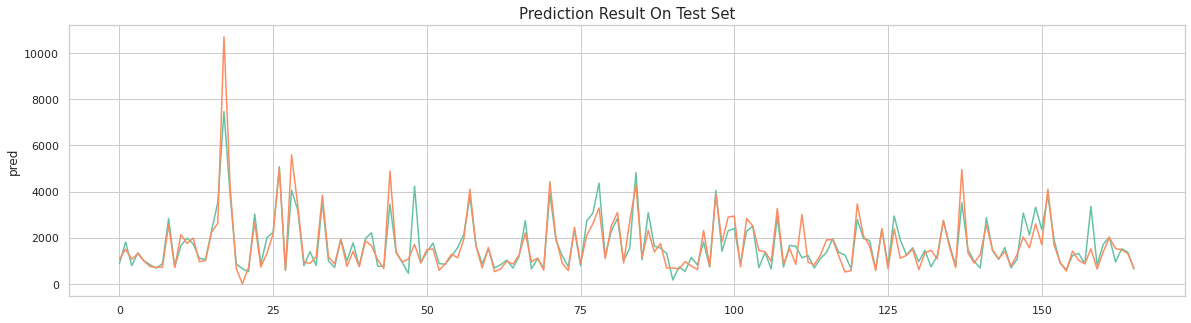

In [396]:
sns.set(style = 'whitegrid')
f = plt.figure(figsize = (20,5))
plt.title('Prediction Result On Test Set', fontsize = 15)
sns.lineplot(x = range(166), y = 'pred', data = test_set, color = sns.color_palette("Set2")[0])
sns.lineplot(x = range(166), y = '进店人数', data = test_set, color = sns.color_palette("Set2")[1])

<Figure size 1440x432 with 0 Axes>

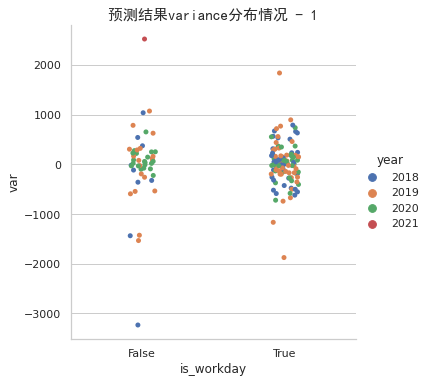

In [522]:
f = plt.figure(figsize = (20,6))
#fig, axes = plt.subplots(nrows = 1,ncols=2)
#sns.set_theme(style = 'whitegrid')

ax = sns.catplot(x = 'is_workday', y = 'var', hue = 'year', data = test_set)
plt.title('预测结果variance分布情况 - 1', font = 'Simhei', fontsize = 15)
#ax = sns.violinplot(x = 'is_workday', y = 'var', data = test_set)
plt.show()

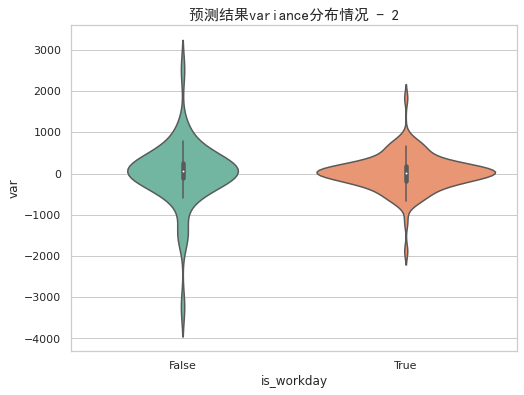

In [512]:
sns.set(style = 'whitegrid')
f = plt.figure(figsize = (8,6))
#fig, axes = plt.subplots(nrows = 1,ncols=2)
#sns.set_theme(style = 'whitegrid')

#ax = sns.catplot(x = 'is_workday', y = 'var', hue = 'year', data = test_set)
plt.title('预测结果variance分布情况 - 2', font = 'Simhei', fontsize = 15)

ax = sns.violinplot(x = 'is_workday', y = 'var', data = test_set, palette = sns.color_palette("Set2"))
plt.show()

Text(0.5, 1.0, 'F3MS Feature Importance Chart')

<AxesSubplot:title={'center':'F3MS Feature Importance Chart'}>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

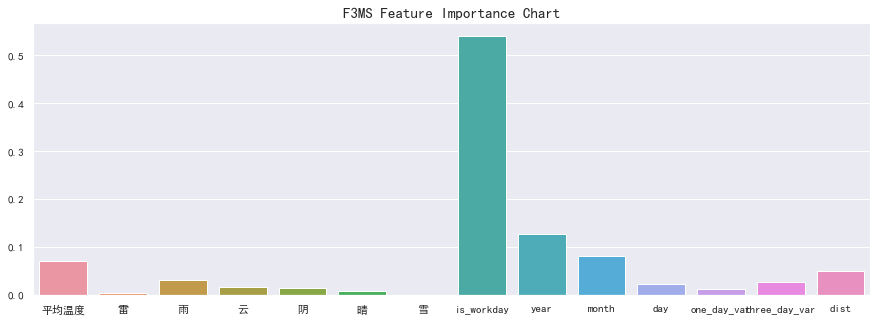

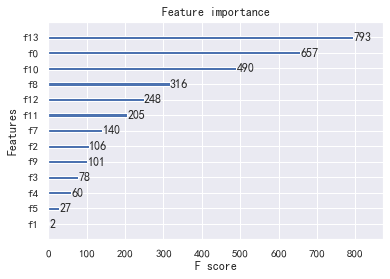

In [367]:
# Feature Importance
f = plt.figure(figsize = (15,5))
plt.title('F3MS Feature Importance Chart', fontsize = 15)
sns.barplot(x = list(features.columns), y = Model_S.feature_importances_)

from xgboost import plot_importance
plot_importance(Model_2)